In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.interpolate import griddata
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt


In [2]:
def get_delta_matrix(training_data):
    """
    Returns a sparse matrix of size k x m where k is number of classes and m is number of samples in the given dataset.
     1.training_data = A dataframe representing the training data set. 
     
    """
    # Build a boolean 2d-array of size k x m comparing each of k classes with each instance's label from m instances
    delta_matrix = np.array([training_data[:][61189]==j for j in range(1,21)])
    
    # Convert the boolean to integer representation
    delta_matrix = delta_matrix.astype(int)
    
    # Return the array as a sparse matrix
    return sparse.csr_matrix(delta_matrix)

In [3]:
def train_weights(training_data,classes,learning_rate,lamda,number_of_iterations):
    """
    Returns a weight matrix by intializing and tuning using the training_data, learning rate and penalty for a specific number of iterations
     1.training_data = A dataframe representing the training data set. 
     2.classes = The list of classes from the file newsgrouplabels.txt  
     2.learning_rate = The learning rate of the gradient function.
     3.lamda = The penalty term used by the gradient funtion
     4.number_of_iterations = Number of iterations to be used to tune the weights
     
    """
    # Initializing the values 
    length_of_vocabulary = len(training_data.iloc[0])-1
    number_of_classes = len(classes)
    
    # Intialize the weights to zero
    weights = np.zeros(shape=(number_of_classes,length_of_vocabulary+1),dtype=np.float64)
    
    # Create a array X_train using training set and normalize it.
    X_train = np.ones(shape=(len(training_data),length_of_vocabulary+1),dtype=np.float64)
    X_train[:,1:] = np.array(training_data.iloc[:,:length_of_vocabulary])
    column_sums = X_train.sum(axis=0)
    column_sums[column_sums==0]=1
    X_train= X_train/column_sums
    
    # Get the delta matrix
    delta_matrix = get_delta_matrix(training_data)
    
    # Converting the weights and X_train 2d arrays into sparse matrices.
    weights = sparse.csr_matrix(weights)
    X_train = sparse.csr_matrix(X_train)
    
    # Tuning the weights for the specified number of iterations
    for i in range(number_of_iterations): 
        
        # Multiplying weights with X_train and applying the sigmoid funtion
        weight_feature_mul_matrix = (weights.dot(X_train.transpose())).expm1()
        
        # Calculating the probability sparse by normalizing the above result.
        prob_matrix = np.ones(shape=(number_of_classes,len(training_data)))
        prob_matrix[:number_of_classes]= (weight_feature_mul_matrix[:number_of_classes]).toarray()
        prob_matrix_column_totals = prob_matrix.sum(axis=0)
        prob_matrix_column_totals[prob_matrix_column_totals==0]=1
        prob_matrix = sparse.csr_matrix(prob_matrix/prob_matrix_column_totals)
        
        # Calculating the change matrix.
        diff_matrix = ((delta_matrix - prob_matrix)*X_train) - lamda*weights
        
        # Updating the weights.
        weights = weights + (learning_rate*diff_matrix)
        
    # Return the weights
    return weights

In [4]:
def generate_output_labels_lr(testing_data,weights):
    """
    Generates the labels for documents from testing dataset using the below parameters.
     1.testing_data = A dataframe representing the testing data set documents to be classified.
     2.weights = The weights matrix tuned on the training data.
     
    """
    # Getting the length of the vocabulary
    length_of_vocabulary = len(testing_data.iloc[0])
    
    # Creating X_test from the testing data and normalizing it.
    X_test = np.ones(shape=(len(testing_data),length_of_vocabulary+1))
    X_test[:,1:] = np.array(testing_data.iloc[:,:length_of_vocabulary])
    X_test_column_totals = X_test.sum(axis=0)
    X_test_column_totals[X_test_column_totals==0]=1
    
    # Converting X_test into sparse matrix
    X_test = sparse.csr_matrix(X_test/X_test_column_totals)
    
    # Multiplying weights with X_test and applying sigmoid on top to get the probabilities.
    outputs =((weights.dot(X_test.transpose())).expm1()).toarray()
    
    # Classifying each instance as the max probability it belongs to and returns the outputs.
    return outputs.argmax(axis=0).flatten()

In [5]:
def get_max_accuracy(training_data, validation_data,classes,learning_rate,lamda, number_of_iterations):
    """
    Returns the max accuracy for the testing data within the specified number of iterations using the training data, learning rate and penalty.
     1.training_data = A dataframe representing the training data set. 
     2.validation_data = A dataframe representing the validation data set documents.
     2.classes = The list of classes from the file newsgrouplabels.txt  
     2.learning_rate = The learning rate of the gradient function.
     3.lamda = The penalty term used by the gradient funtion
     4.number_of_iterations = Number of iterations to be used to tune the weights
    """
     # Initializing the values 
    length_of_vocabulary = len(training_data.iloc[0])-1
    number_of_classes = len(classes)   
    true_outputs= np.array(validation_data.iloc[:,-1])

    
    # Intialize the weights to one
    weights = np.zeros(shape=(number_of_classes,length_of_vocabulary+1),dtype=np.float64) 
    
    # Create a array X_train using training set and normalize it.
    X_train = np.ones(shape=(len(training_data),length_of_vocabulary+1),dtype=np.float64)
    X_train[:,1:] = (np.array(training_data))[:,:length_of_vocabulary]
    column_sums = X_train.sum(axis=0)
    column_sums[column_sums==0]=1
    X_train= X_train/column_sums
    
    # Get the delta matrix
    delta_matrix = get_delta_matrix(training_data)
    
    # Converting the weights and X_train 2d arrays into sparse matrices.
    weights = sparse.csr_matrix(weights)
    X_train = sparse.csr_matrix(X_train)
    
    # Tuning the weights for the specified number of iterations.
    for i in range(number_of_iterations): 
        # Multiplying weights with X_train and applying the sigmoid funtion.
        weight_feature_mul_matrix = (weights.dot(X_train.transpose())).expm1()
        
        # Calculating the probability sparse by normalizing the above result.
        prob_matrix = np.ones(shape=(number_of_classes,len(training_data)))
        prob_matrix[:number_of_classes]= (weight_feature_mul_matrix[:number_of_classes]).toarray()
        prob_matrix_column_totals = prob_matrix.sum(axis=0)
        prob_matrix_column_totals[prob_matrix_column_totals==0]=1
        prob_matrix = sparse.csr_matrix(prob_matrix/prob_matrix_column_totals)
        
        # Calculating the change matrix.
        diff_matrix = ((delta_matrix - prob_matrix)*X_train) - lamda*weights
        
        # Updating the weights.
        weights = weights + (learning_rate*diff_matrix)     

        
    # Generate outputs for the validation set using the current weights.
    actual_outputs = generate_output_labels_lr(validation_data.iloc[:,:-1],weights)
    actual_outputs = actual_outputs + 1 
    
    # Calculate accuracy using the current weights.
    accuracy = accuracy_score(true_outputs,actual_outputs)
        
    
    # Return maximum accuracy and the predicted labels.
    return accuracy,actual_outputs

In [6]:
def classify_testing_documents_lr(training_data,testing_data):
    """
    Classifies the test documents and writes them to file using the below parameters.
     1.training_data = A dataframe representing the training data set. 
     2.testing_data = A dataframe representing the testing data set documents to be classified.
     
    """
    # Intializing the learning rate and penalty to 0.05
    learning_rate = 0.05
    lamda = 0.05
    
    # Getting the weights tuned on the training data.
    weights = train_weights(training_data,label_names,learning_rate,lamda,5) 
    
    # Getting the predicted labels for the testing data instances.
    Y_pred = generate_output_labels_lr(testing_data,weights)
    
    # Writing the predictions to a daraframe in the required format.
    df = pd.DataFrame(columns=['id','class'])
    for i in range(len(Y_pred)):
        df.at[i,'id']=12001+i    
        df.at[i,'class']= Y_pred[i]+1
        
    # Writing the dataframe to a filename results_lr.csv
    df.to_csv('results_lr.csv',index=False)

In [7]:
def plot_confusion_matrix(y_true,y_pred,label_names):
    """
    Draws a confusion matrix for the given y_pred and y_true values.
     1. y_true = The actual classifications of the documents in the test dataset.
     2. y_pred = The predicted classifications of the documents from the test dataset.
     3. label_names = The actual names of the classes.    
    """
    
    # Calculate the confusion matrix using the expected and predicted values.
    confusion_mat = confusion_matrix(np.array(y_true),y_pred,label_names)
    
    #  Show the confusion matrix values.
    fig = plt.figure(figsize=(15,15))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
    
    # Set the x, y and title labels for the plot.
    plt.xlabel("Expected Outputes", fontsize=14)
    plt.ylabel("Actual Outputs", fontsize=14)
    plt.title("Confusion Matrix",fontsize=16)
    
    # Arrange the label names on the x and y axis.
    plt.xticks(np.arange(len(label_names)), label_names, rotation='75')
    plt.yticks(np.arange(len(label_names)), label_names)
    plt.tick_params(axis='both', labelsize='12')
    plt.tight_layout()
    for (y, x), label in np.ndenumerate(confusion_mat):
        if label != 0:
            plt.text(x,y,label,ha='center',va='center', size='14')
    # Show the plot
    plt.show()

In [12]:
def plot_accuracies(training_data,eta_values,lamdba_values,label_names):
    """
    Classifies the test documents and writes them to file using the below parameters.
     1.training_data = A dataframe representing the training data set. 
     2.beta_list = A list of beta values we want to compare the accuracy for.
     3.label_names = Label names of the classes.
     
    """
    # Split the training data in the ration 8:2 as the train and validation sets.
    # Performing stratified split to make sure we preserve same percentage of samples from each class.
    train_labels = np.array(training_data[61189])

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    for train_index, test_index in stratified_split.split(np.array(training_data), train_labels):
        train_set, validation_set=training_data.iloc[train_index],training_data.iloc[test_index]

    # Getting the true outputs of the documents from the validation dataset.
    true_outputs= np.array(validation_set.iloc[:,-1])

    # Creating empty lists to add the co-ordinates and accuracies.

    x_coords = []
    y_coords = []
    z_coords = []   

    # Looping on each eta and lambda values.
    for x in range(len(eta_values)):

        for y in range(len(lamdba_values)):            

            # Add the current eta and lamda values to the x and y co-ordinates list.
            x_coords.append(eta_values[x])
            y_coords.append(lamdba_values[y])

            # Calculationg and adding accuracy to the list.
            validation_accuracy,predicted_outputs = get_max_accuracy(train_set,validation_set,label_names,eta_values[x],lamdba_values[y],10)

            # Getting the corresponding label names for the classificaitions.
            actual_outputs= [label_names[predicted_outputs[i]-1] for i in range(len(predicted_outputs))]
            expected_outputs= [label_names[true_outputs[i]-1] for i in range(len(true_outputs))]

            # Add the accuracy to the z co-ordinates list.
            z_coords.append(validation_accuracy)

            # Printing the Current Parameters and Confusion Matrix 
            print('Eta: '+str(eta_values[x])+ ' \t Lambda: ' + str(lamdba_values[y]))
            print('\n Accuracy: '+ str(validation_accuracy))
            print('\n Confusion Matrix: \n')
            plot_confusion_matrix(np.array(expected_outputs),actual_outputs,label_names)
            print('\n')

    # Plotting a 3D Grapgh for the eta_values, lamdba_values and accuracies.
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    z_coords = np.array(z_coords)
    z_coords = z_coords * 100

    # Plot a figure and set it to 3d.
    fig = plt.figure(figsize=(10,10))

    # Set the projection to 3d
    ax = plt.axes(projection="3d")

    # Set the labels for each axis.
    ax.set_xlabel('learning rate')
    ax.set_ylabel('penalty')
    ax.set_zlabel('accuracy')

    # Get the boundaries for x and y axis.
    x_bounds = np.linspace(min(x_coords), max(x_coords))
    y_bounds = np.linspace(min(y_coords), max(y_coords))

    # Get the Z co-ordinates using griddate and plot the surface.
    X, Y = np.meshgrid(x_bounds, y_bounds)
    Z = griddata((x_coords, y_coords), z_coords, (X, Y), method='linear')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='winter',antialiased=False, edgecolor='none')

    # Set the title for the  graph.
    ax.set_title('Accuracy at various Learning Rates and Penalties')

    # Show the plot.
    plt.show()        

In [9]:
# Load the training and testing dataframes from CSV files
training_data = (pd.read_csv('training.csv',header=None)).drop(0,axis=1)
testing_data = (pd.read_csv('testing.csv',header=None)).drop(0,axis=1)

In [10]:
learning_rate_list = [.0001,.0005, .001, .005,  .01,.05, .1]
penalty_term_list = [.0001,.0005,  .001,  .005,  .01,.05, .1]
label_names = np.loadtxt("newsgrouplabels.txt",dtype='str', usecols=1)

In [ ]:
classify_testing_documents_lr(training_data,testing_data)

Eta: 0.0001 	 Lambda: 0.0001

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



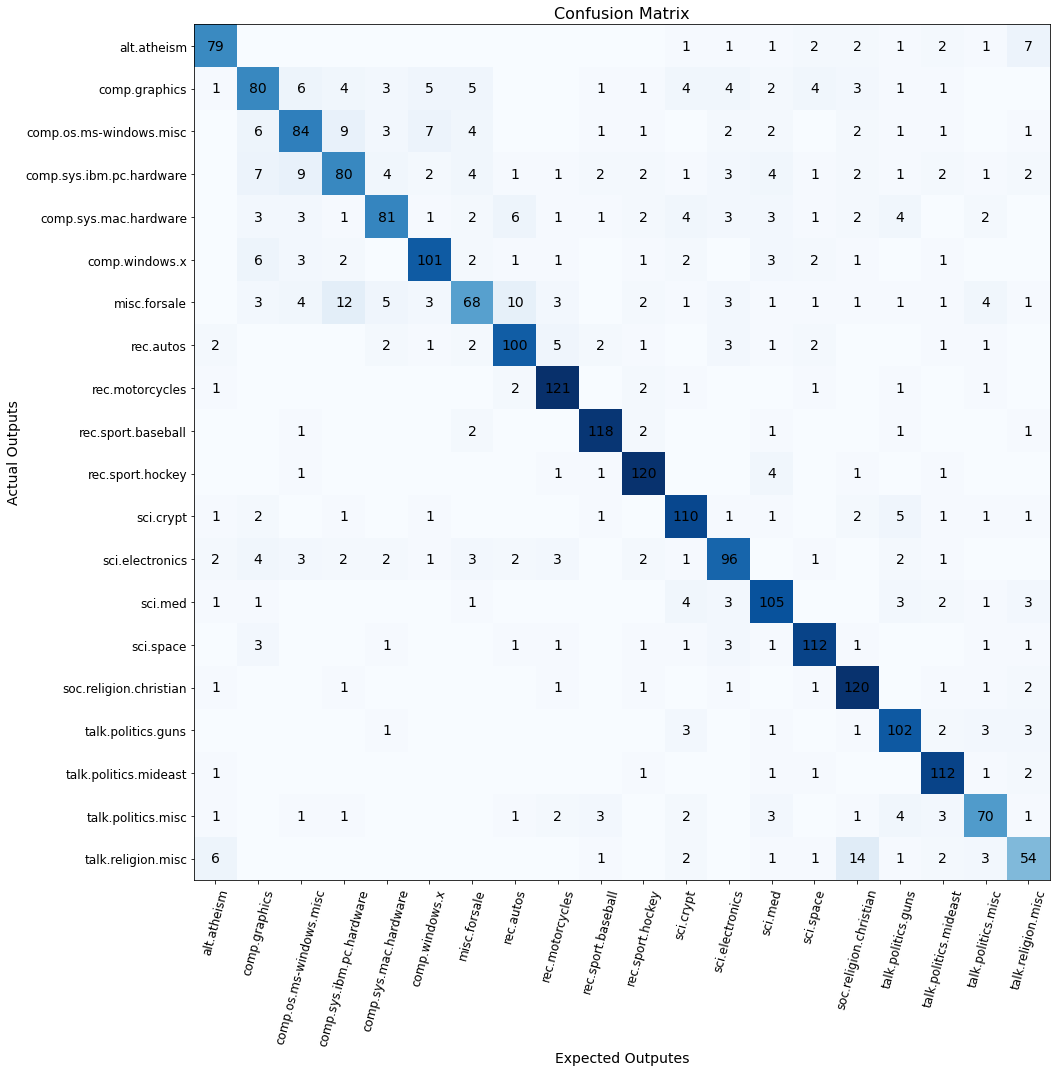



Eta: 0.0001 	 Lambda: 0.0005

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



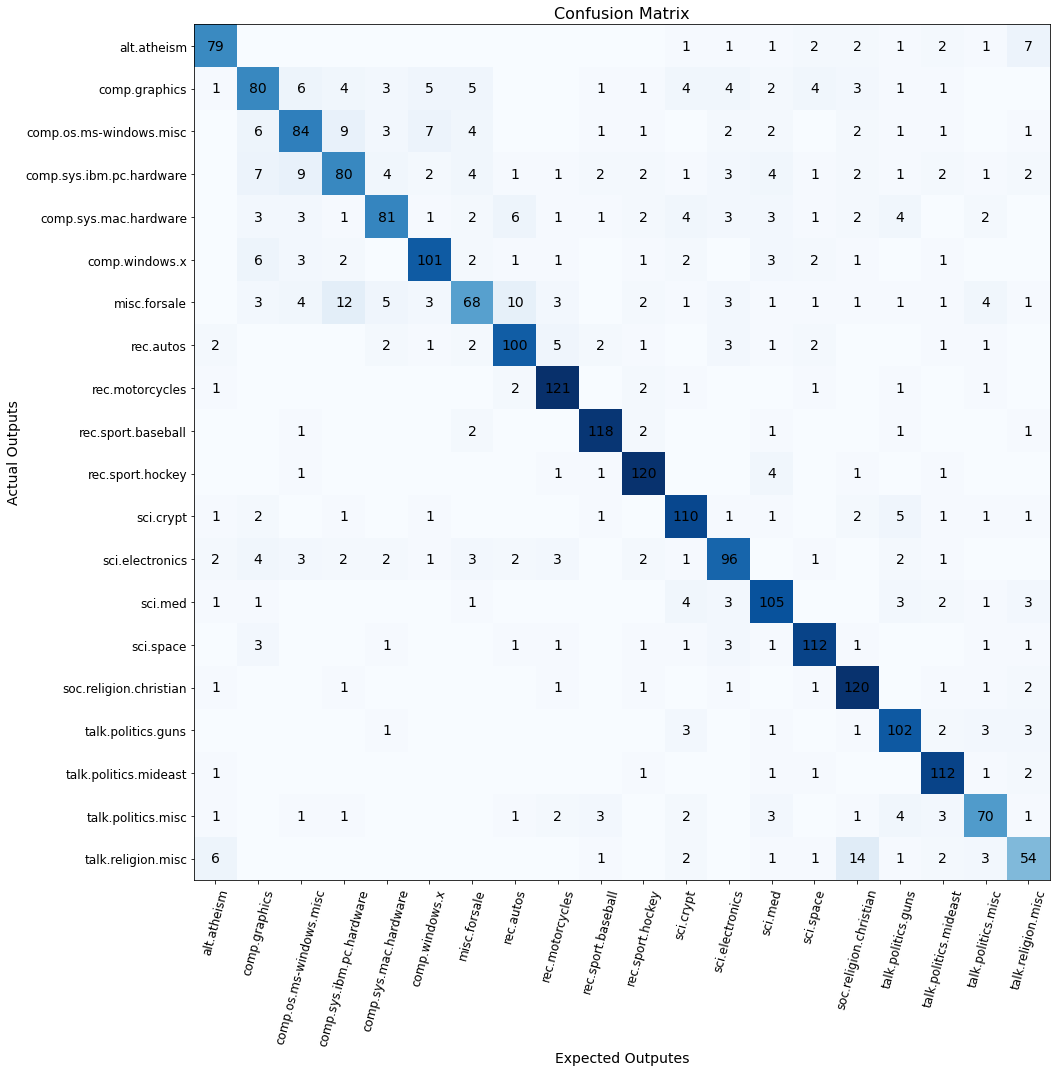



Eta: 0.0001 	 Lambda: 0.001

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



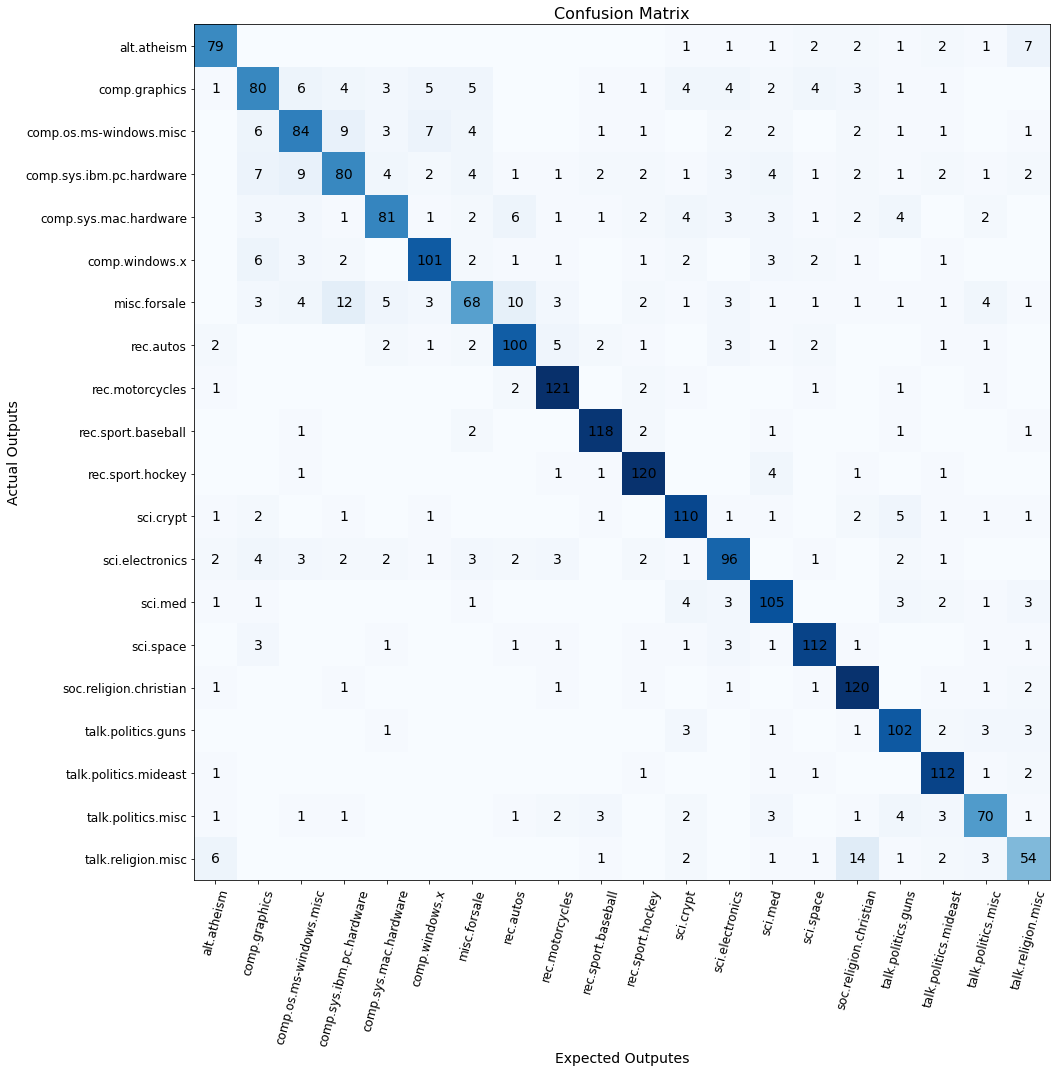



Eta: 0.0001 	 Lambda: 0.005

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



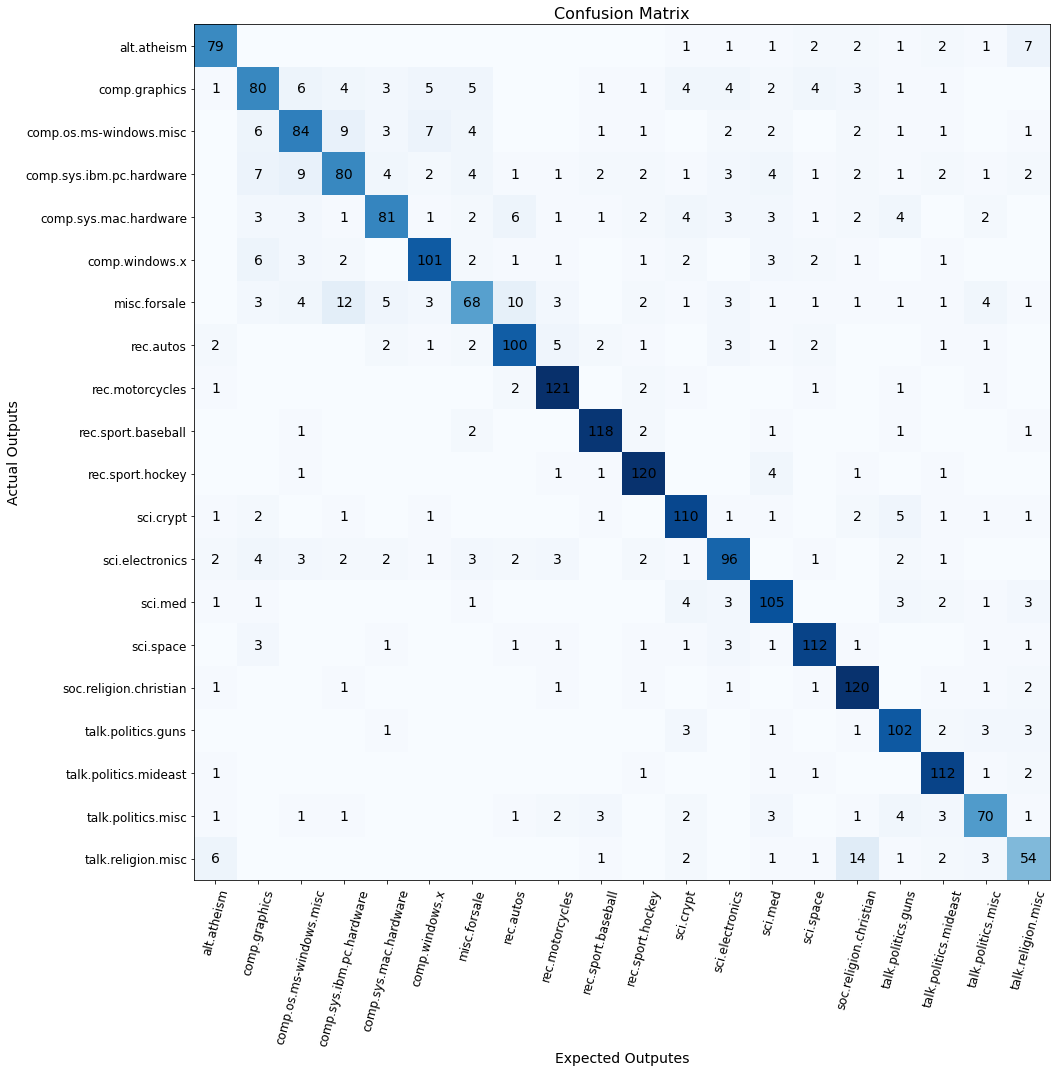



Eta: 0.0001 	 Lambda: 0.01

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



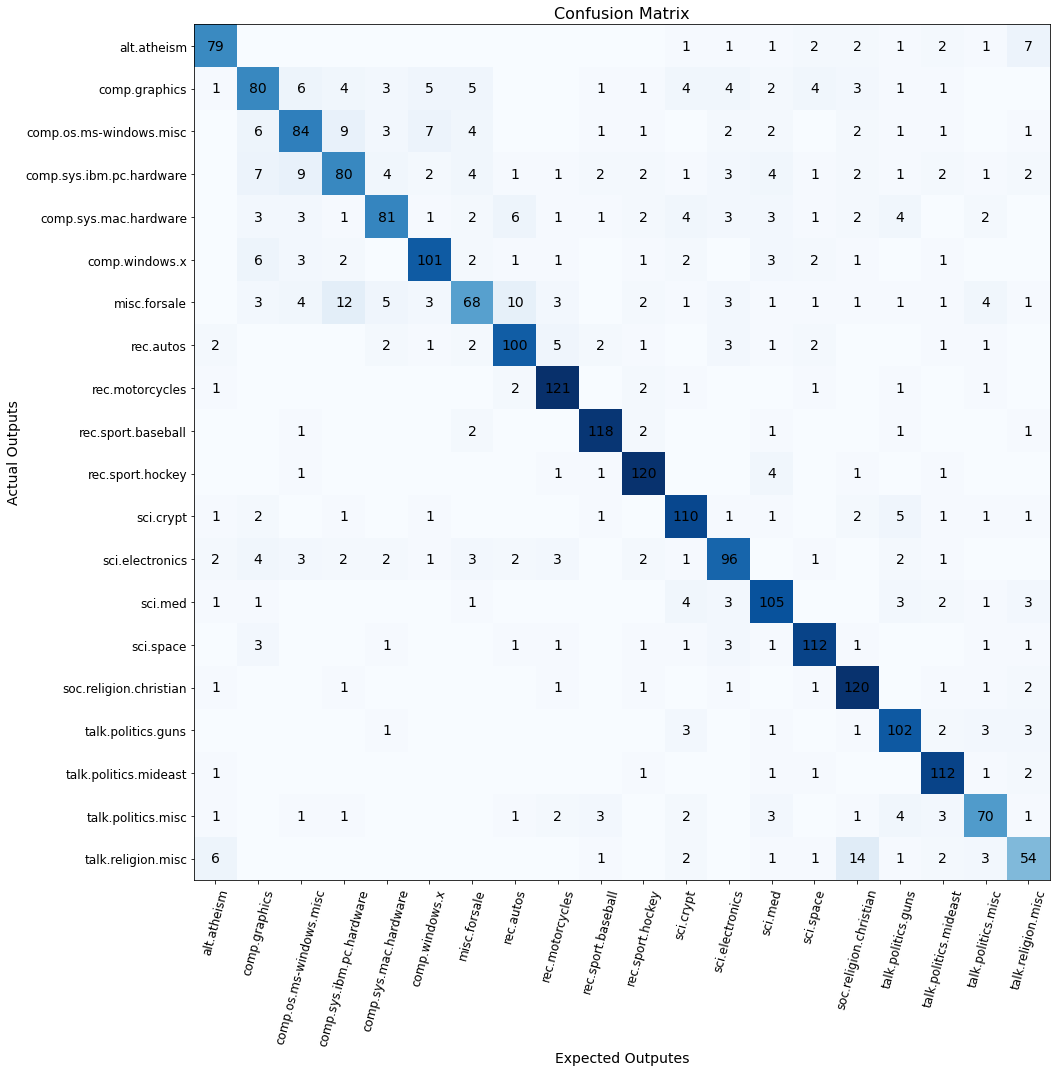



Eta: 0.0001 	 Lambda: 0.05

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



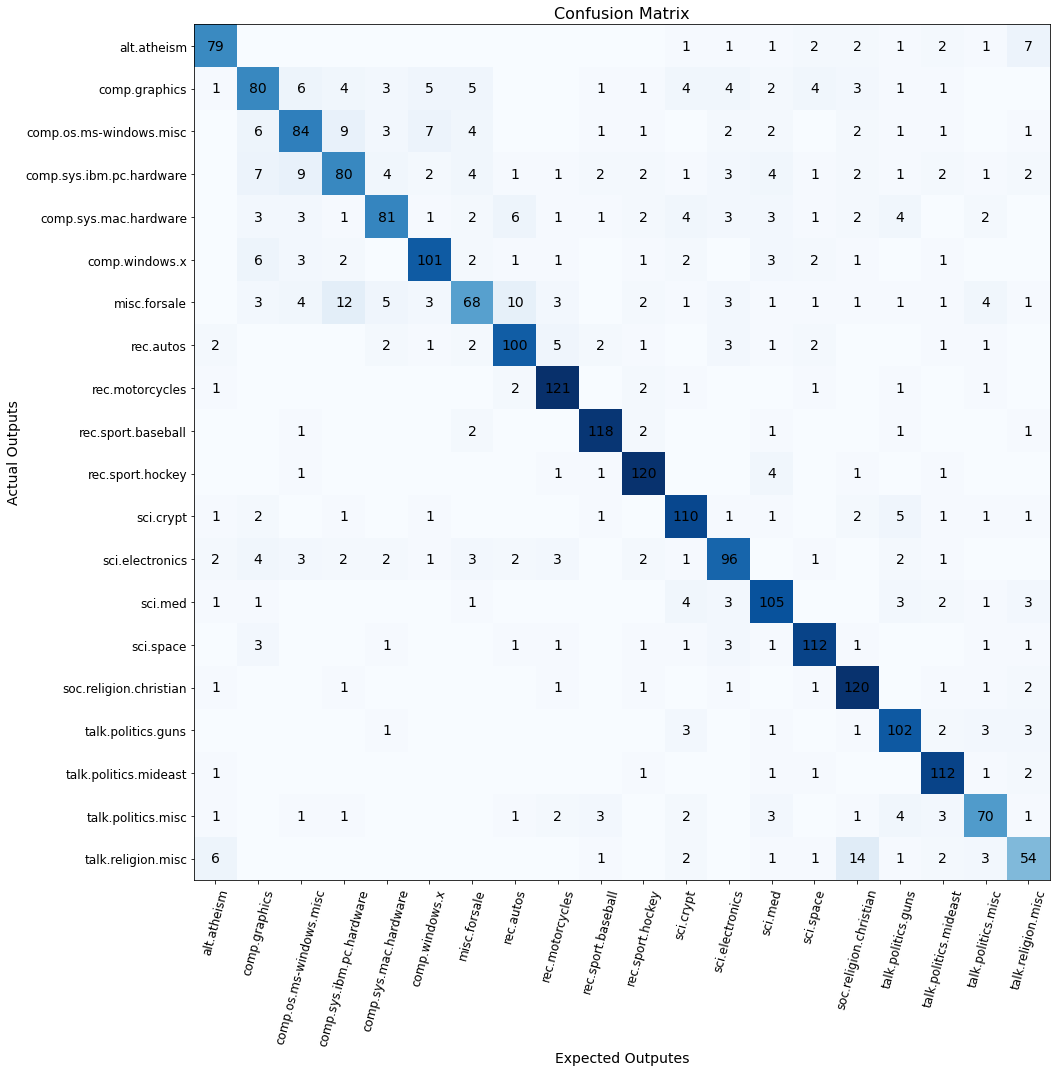



Eta: 0.0001 	 Lambda: 0.1

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



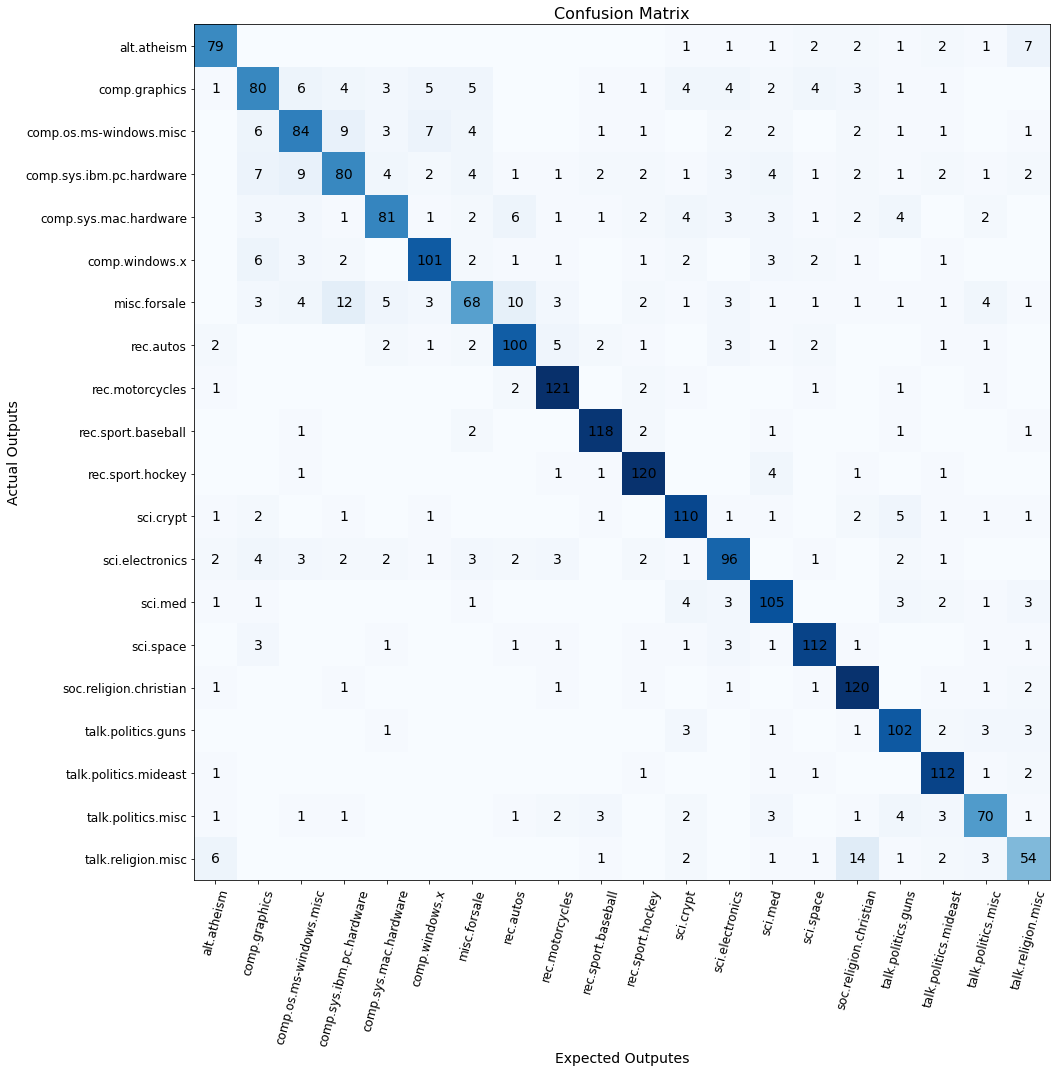



Eta: 0.0005 	 Lambda: 0.0001

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



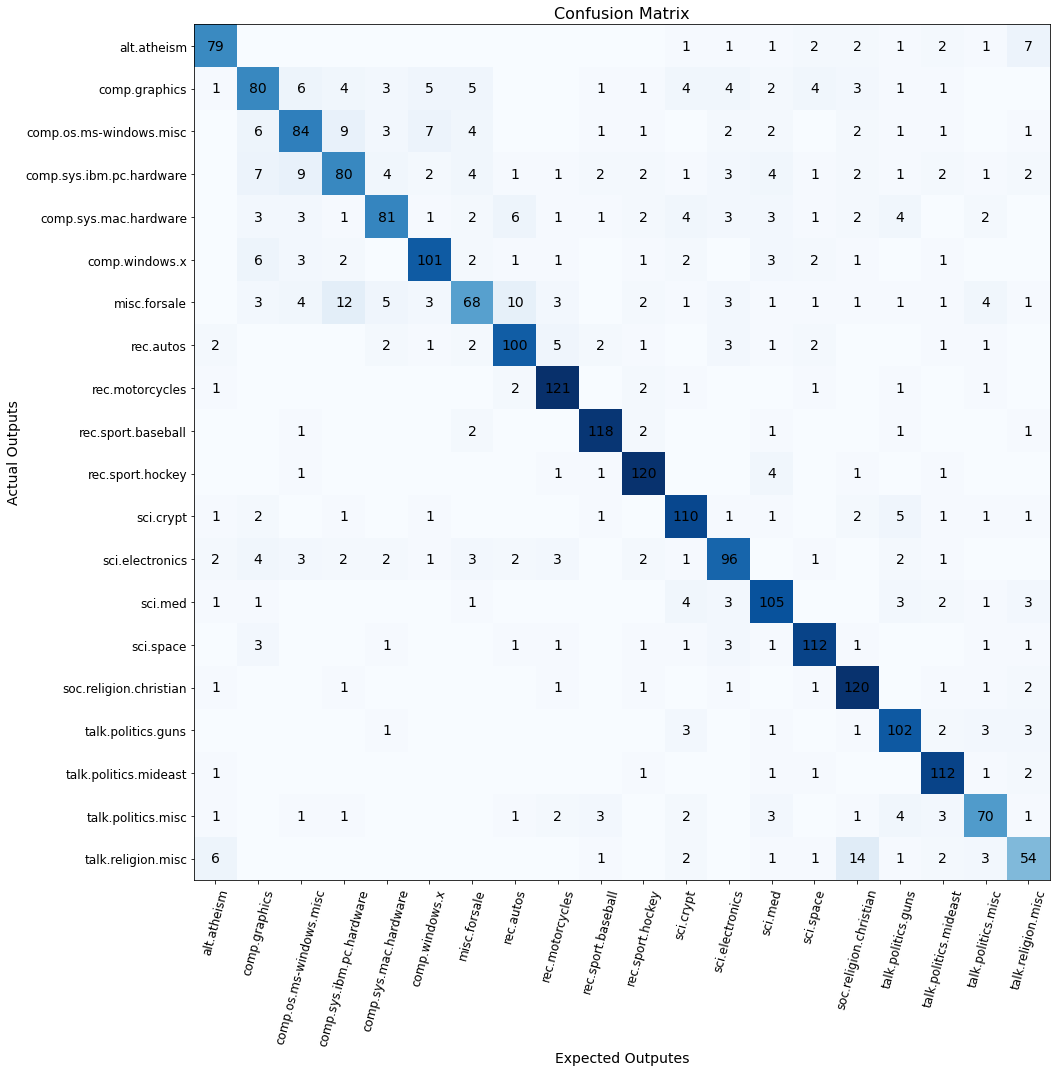



Eta: 0.0005 	 Lambda: 0.0005

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



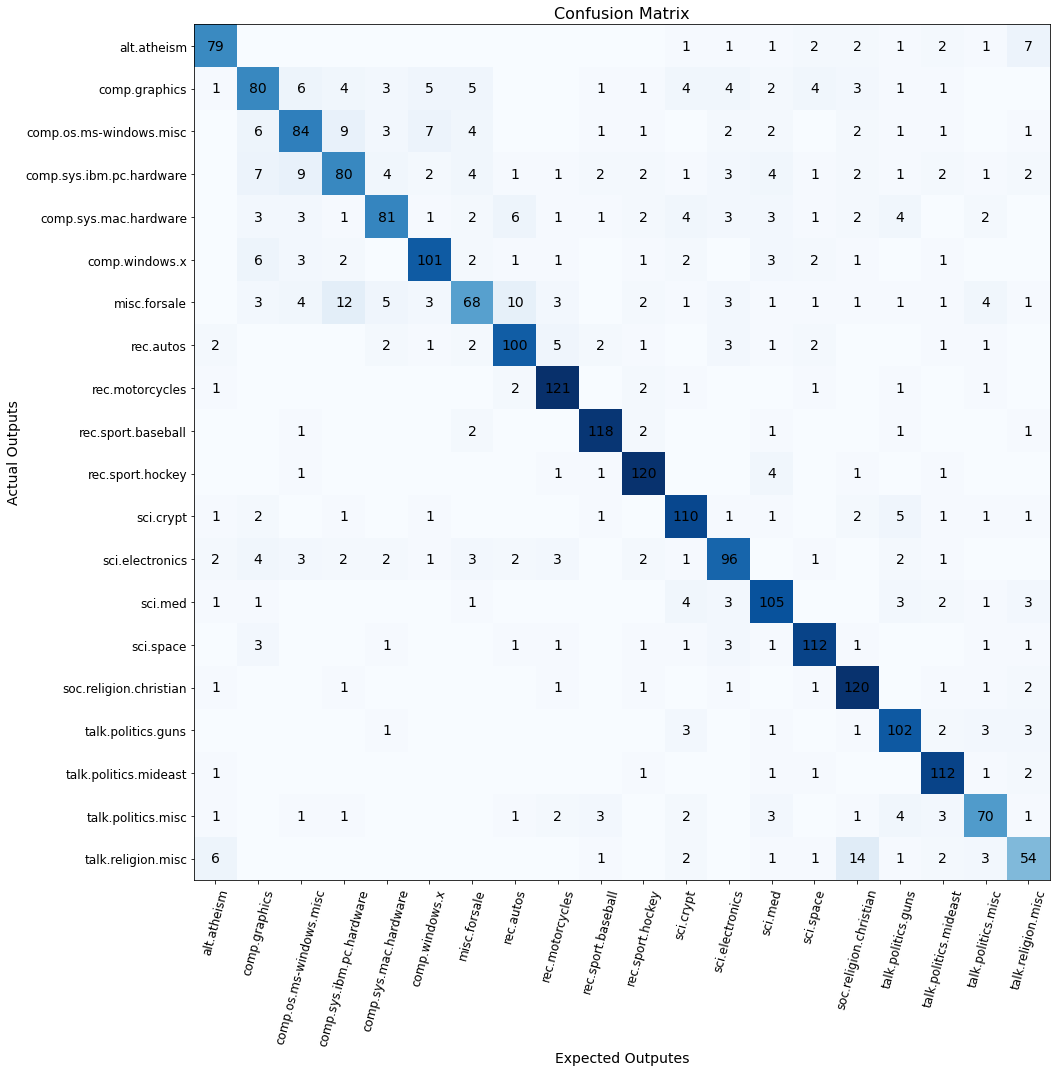



Eta: 0.0005 	 Lambda: 0.001

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



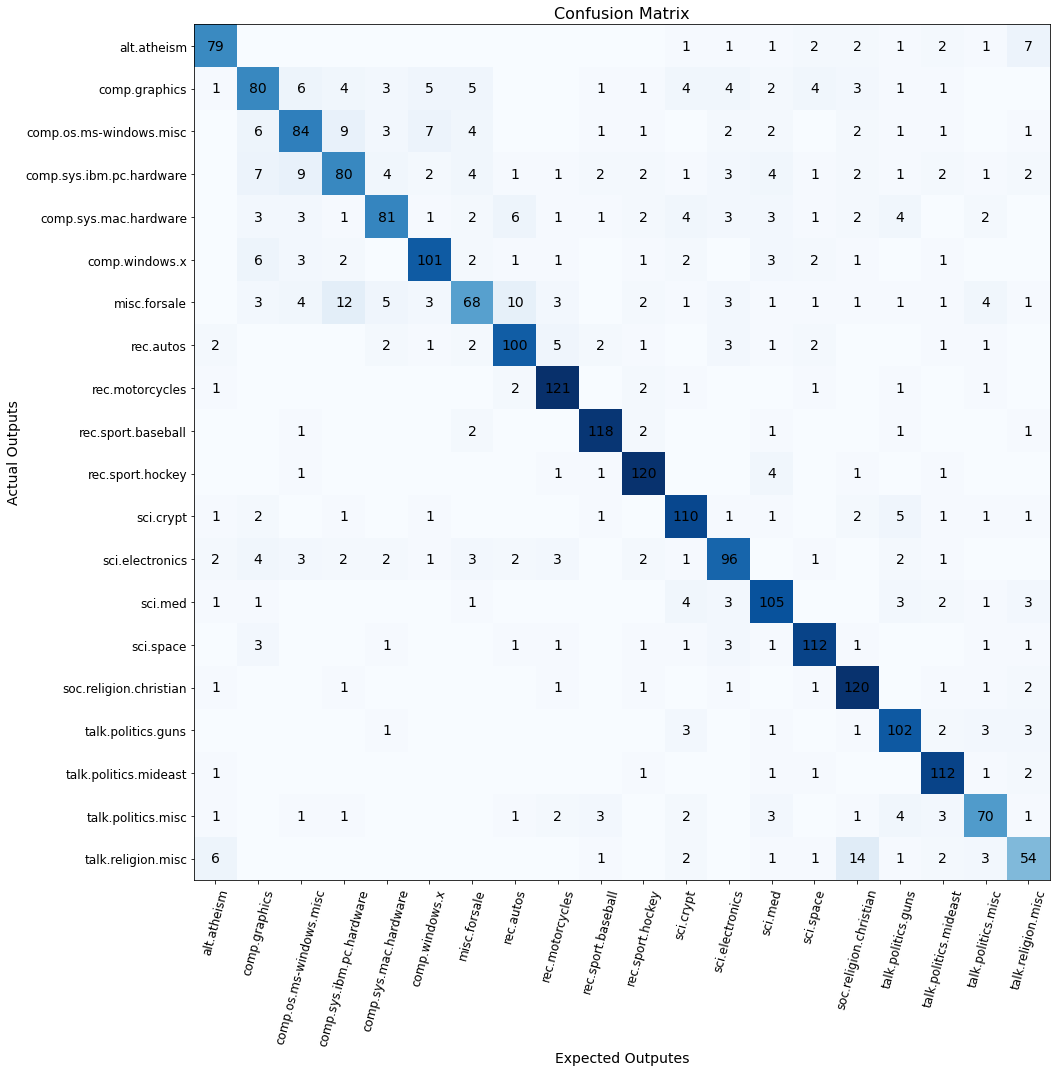



Eta: 0.0005 	 Lambda: 0.005

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



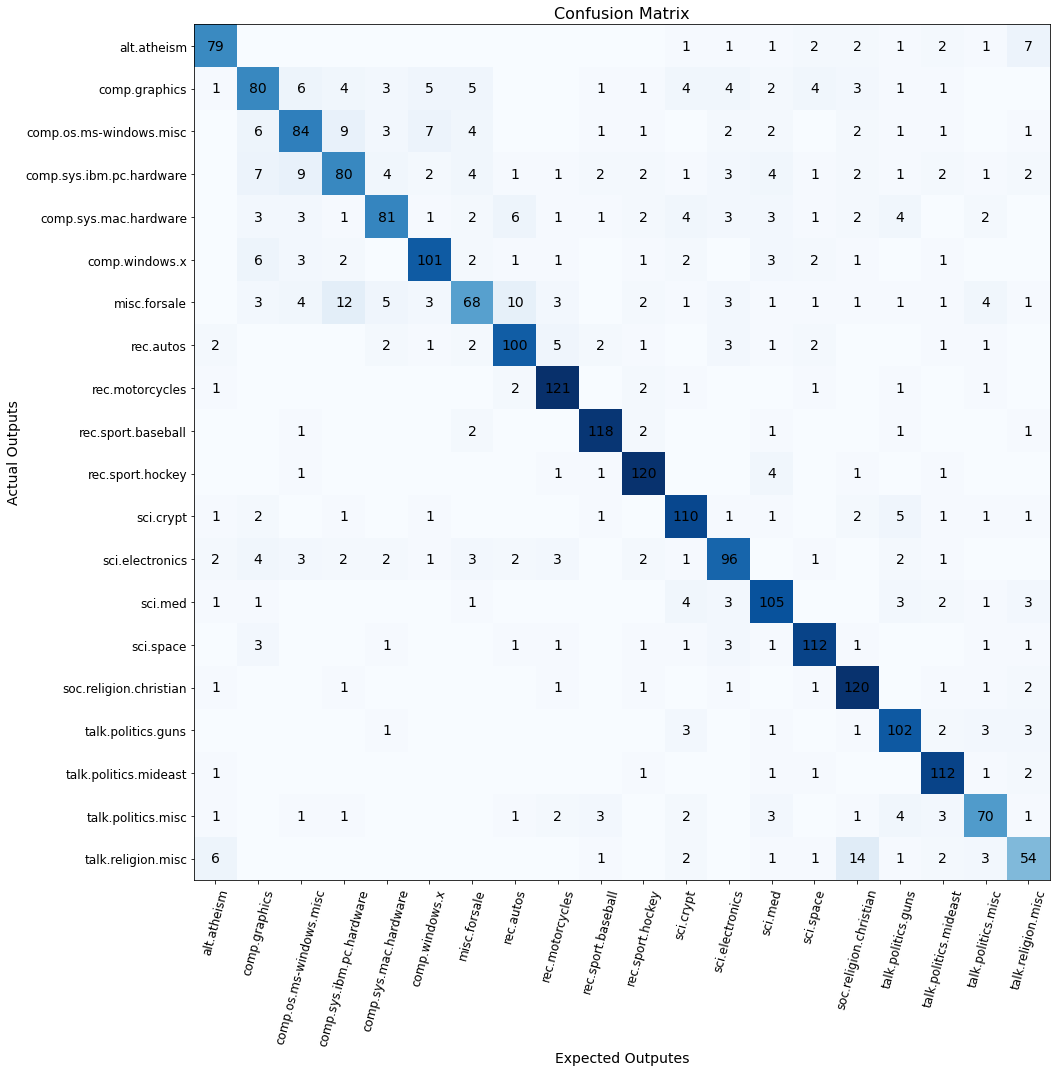



Eta: 0.0005 	 Lambda: 0.01

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



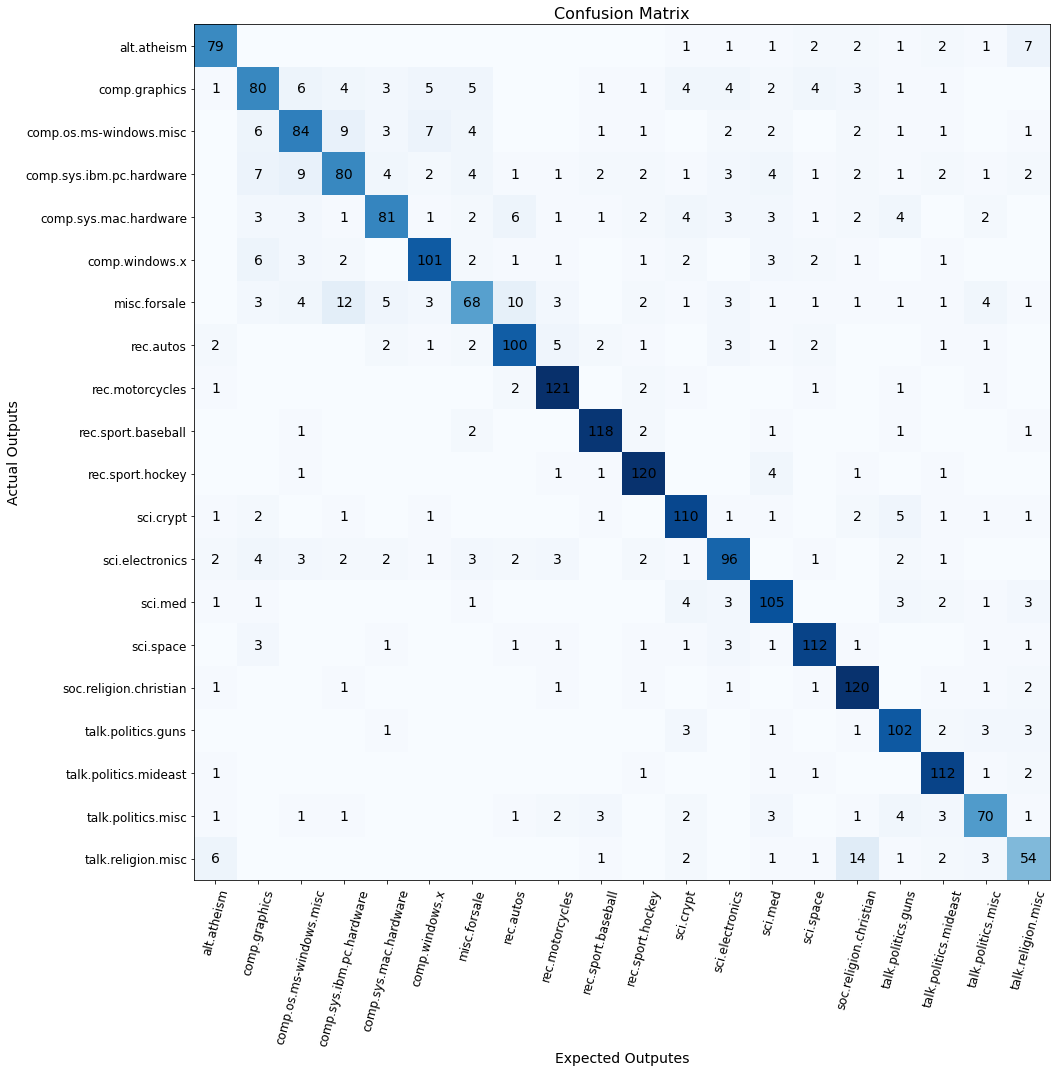



Eta: 0.0005 	 Lambda: 0.05

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



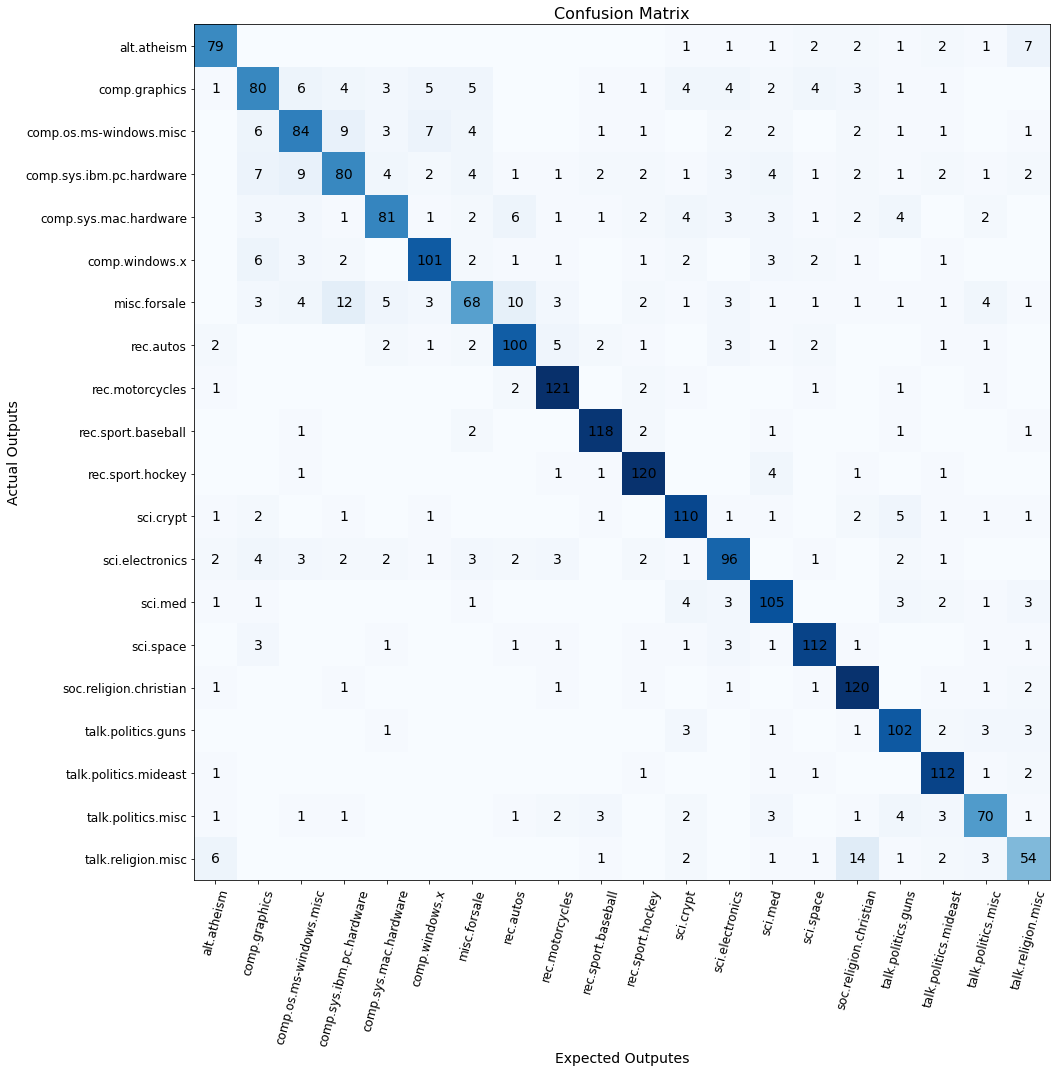



Eta: 0.0005 	 Lambda: 0.1

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



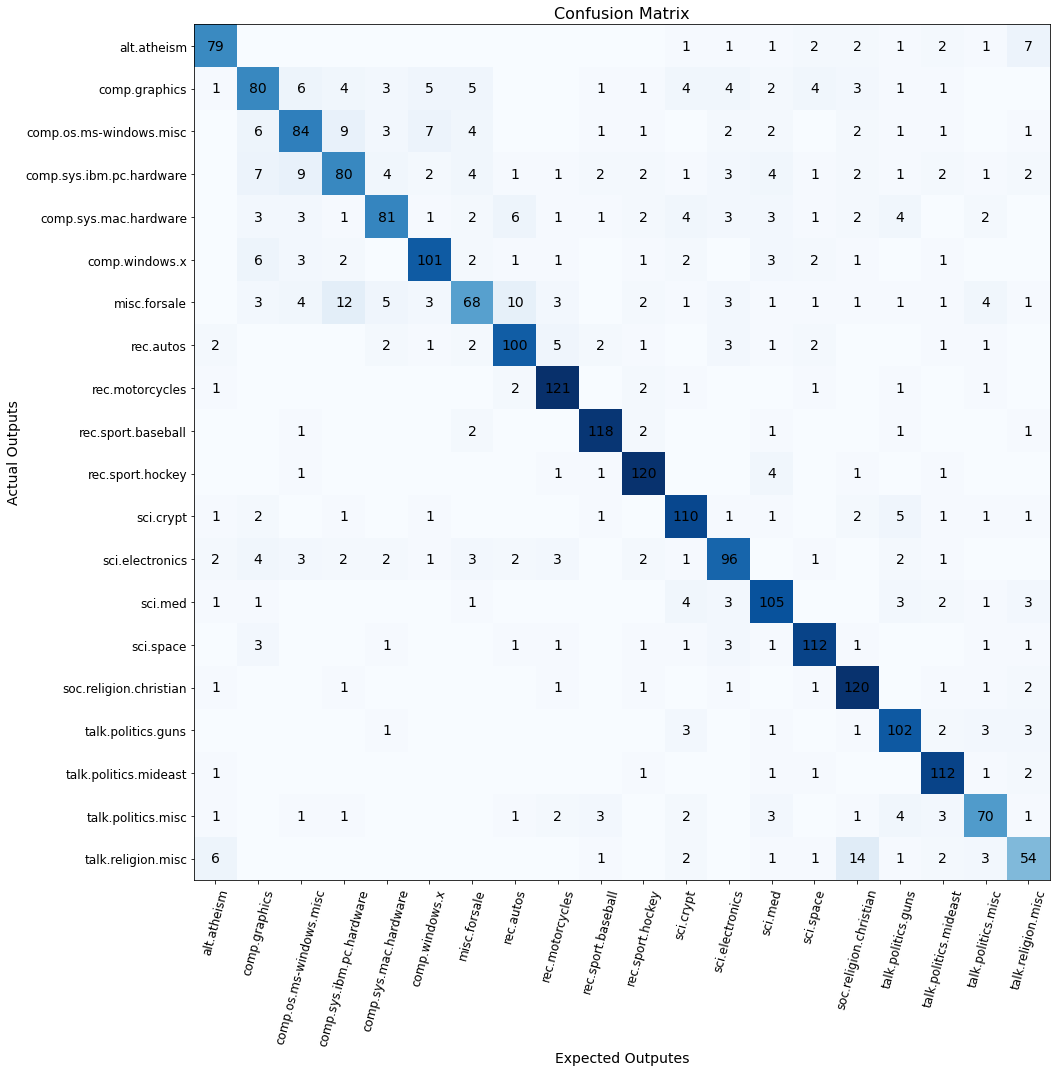



Eta: 0.001 	 Lambda: 0.0001

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



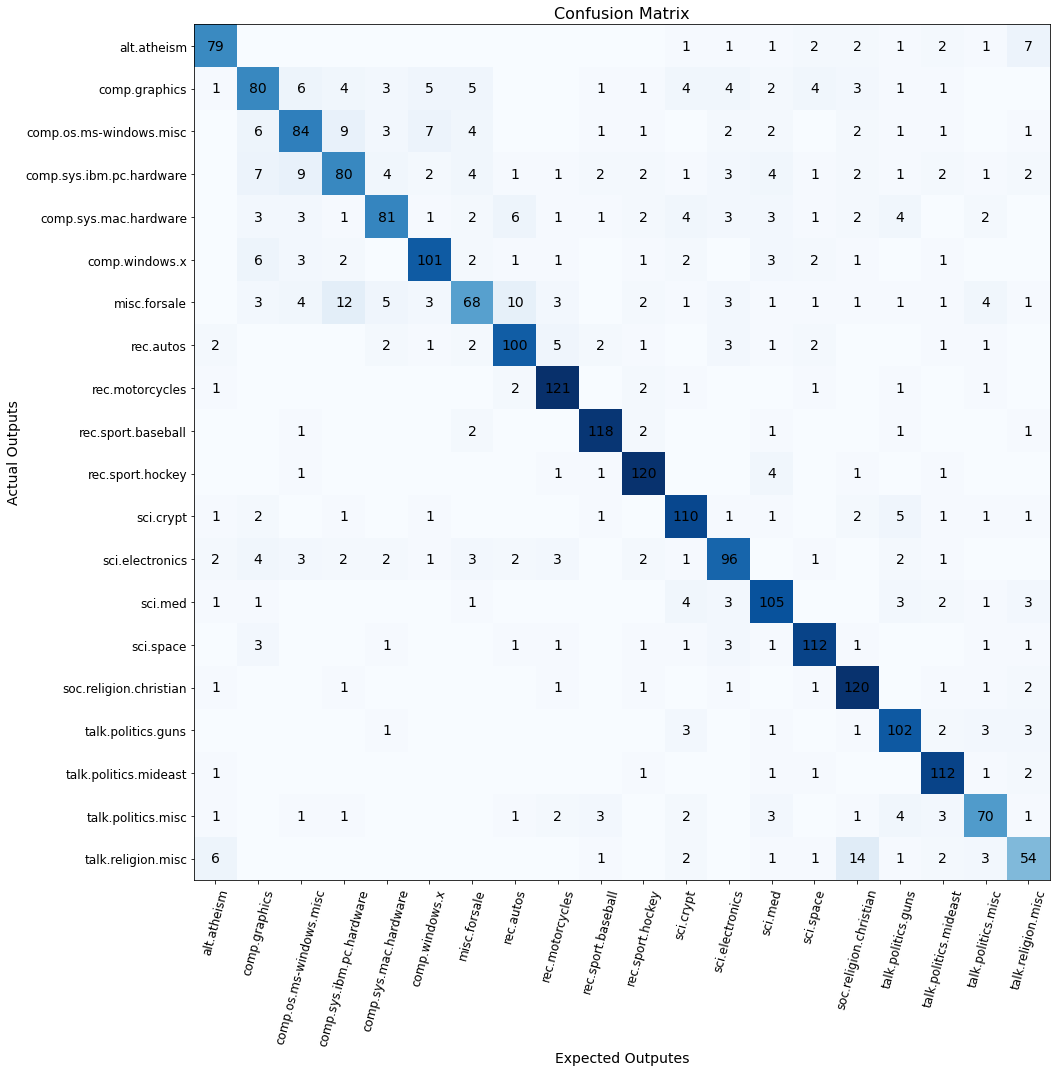



Eta: 0.001 	 Lambda: 0.0005

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



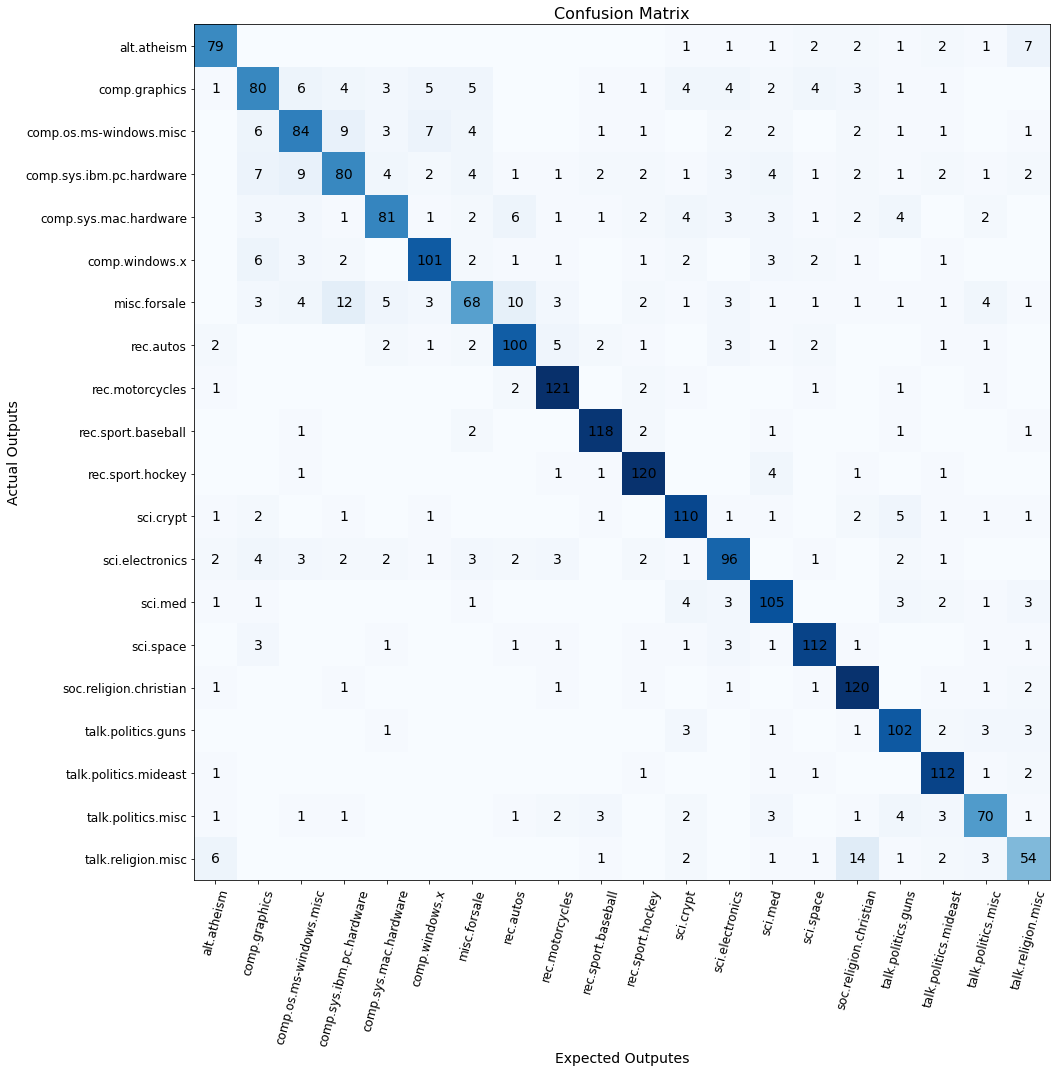



Eta: 0.001 	 Lambda: 0.001

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



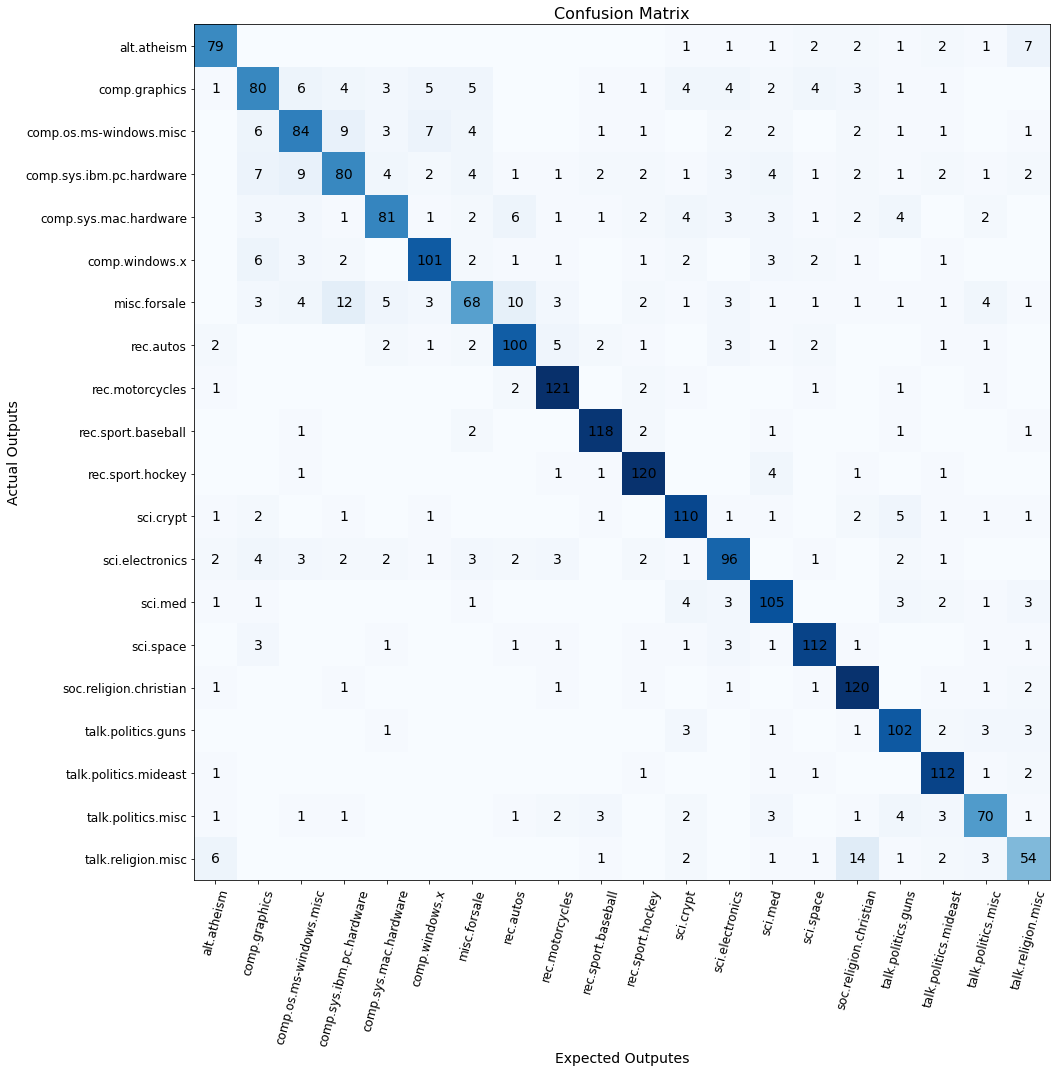



Eta: 0.001 	 Lambda: 0.005

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



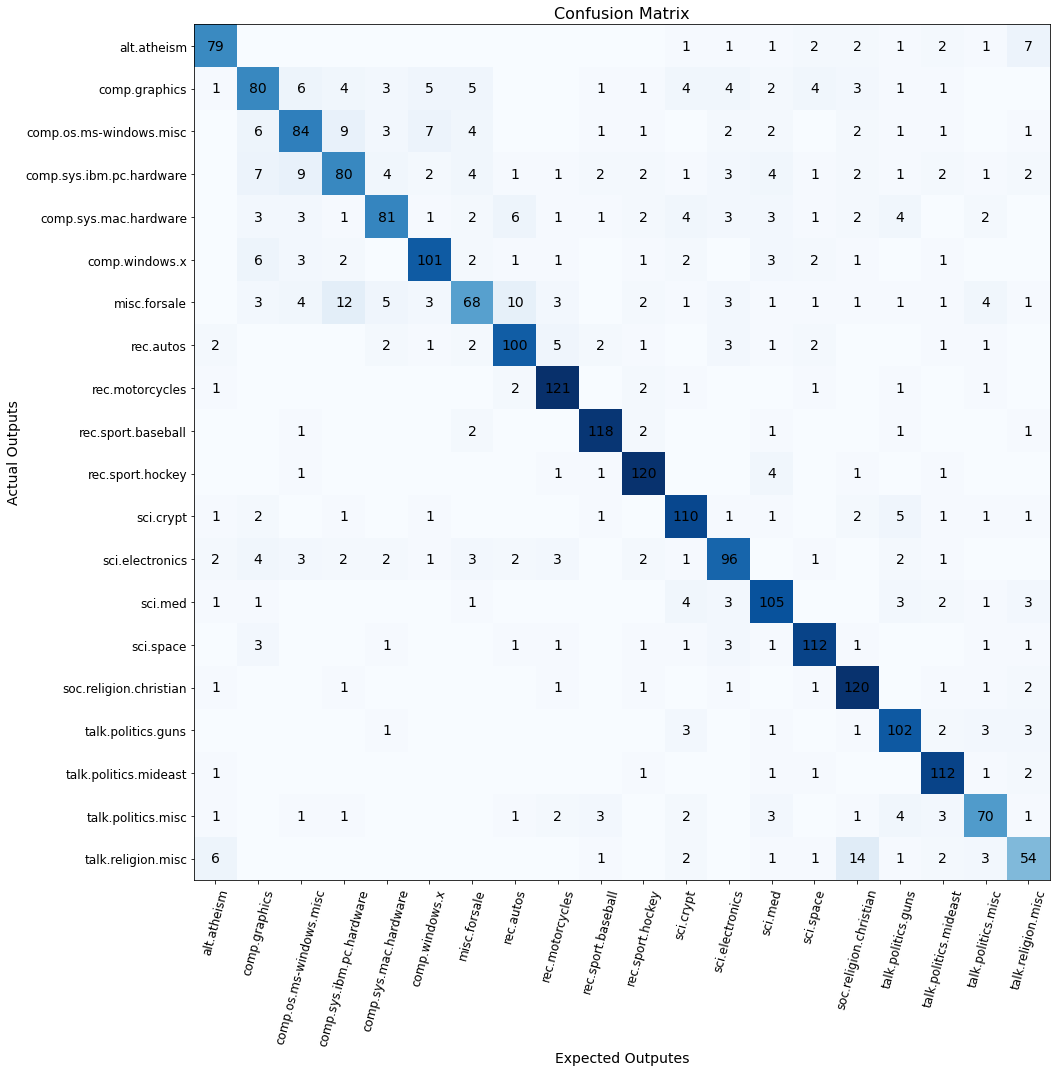



Eta: 0.001 	 Lambda: 0.01

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



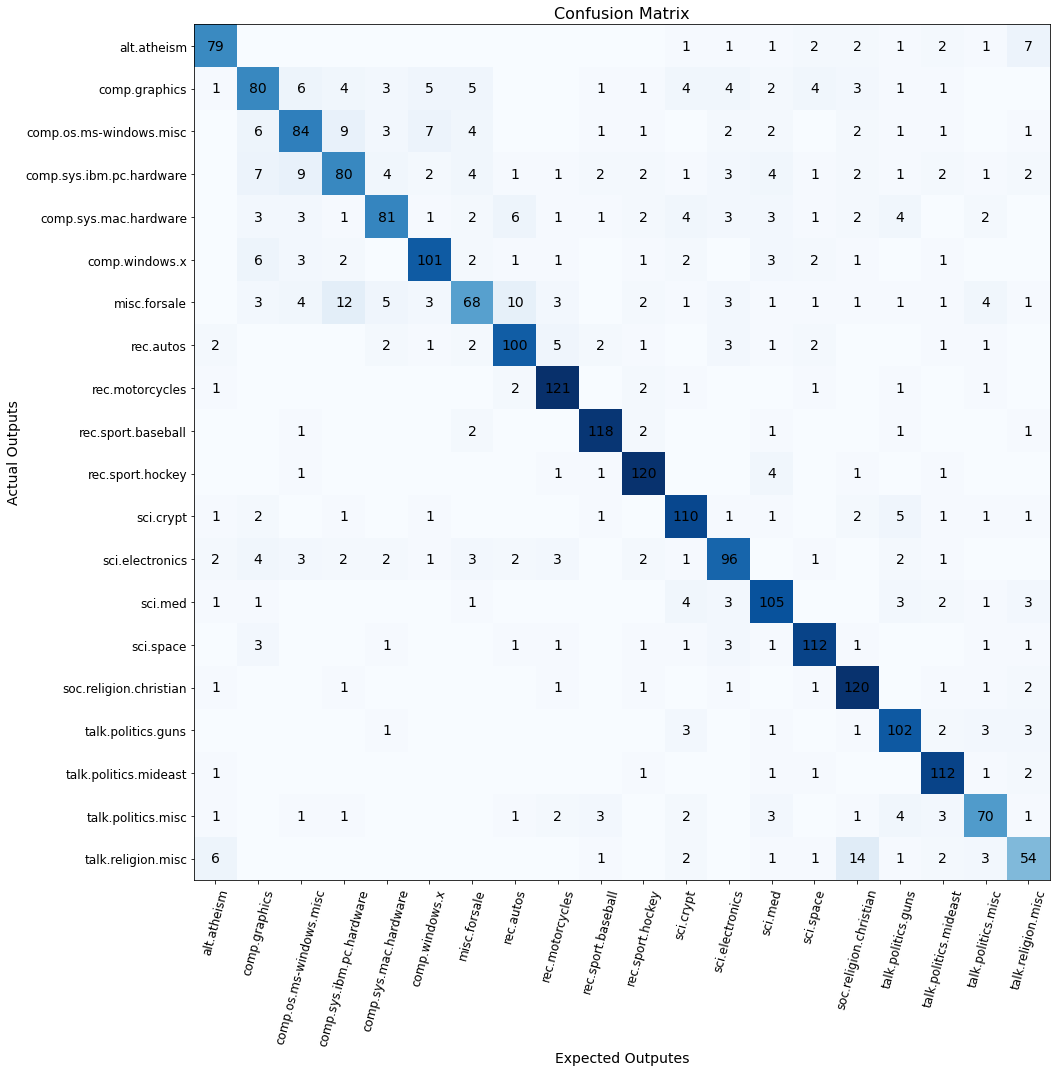



Eta: 0.001 	 Lambda: 0.05

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



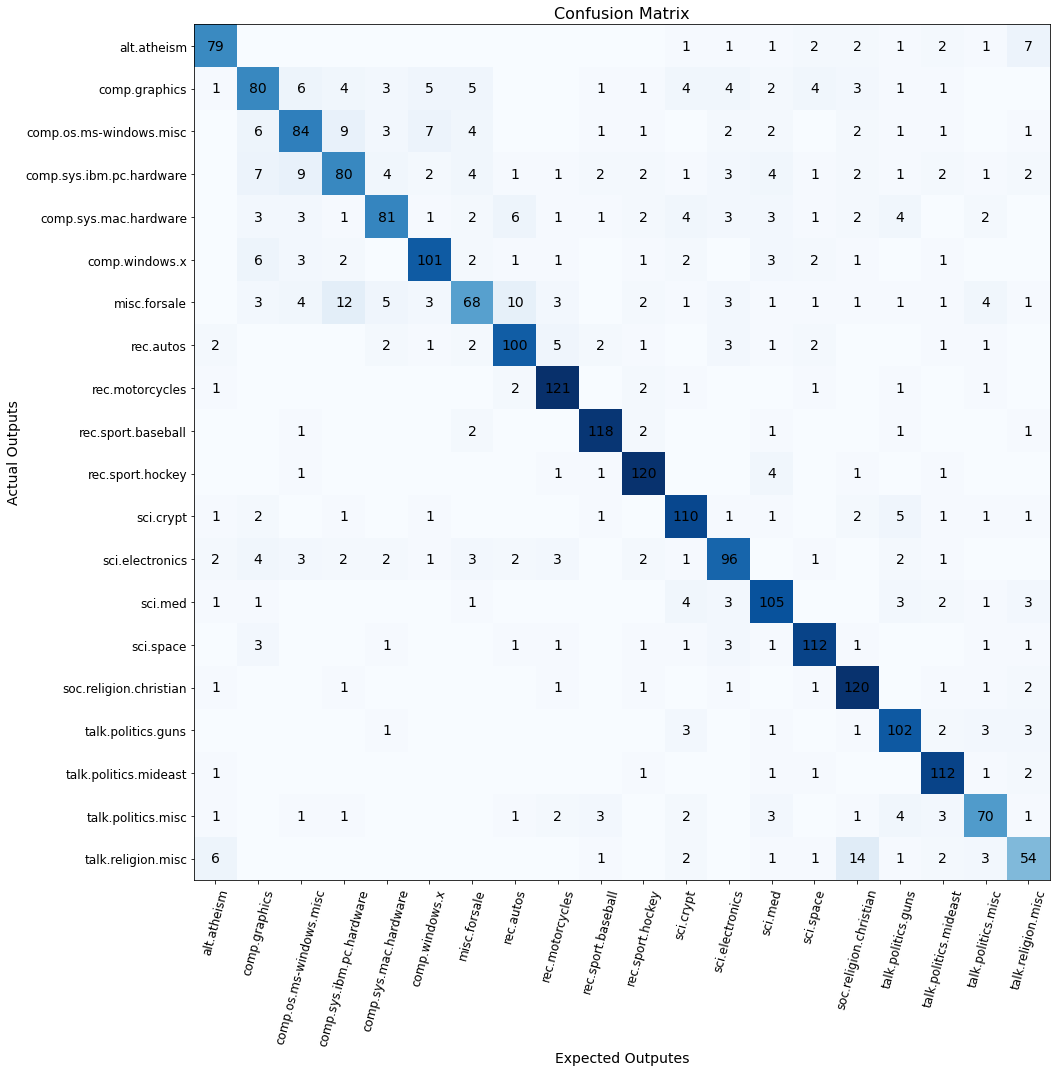



Eta: 0.001 	 Lambda: 0.1

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



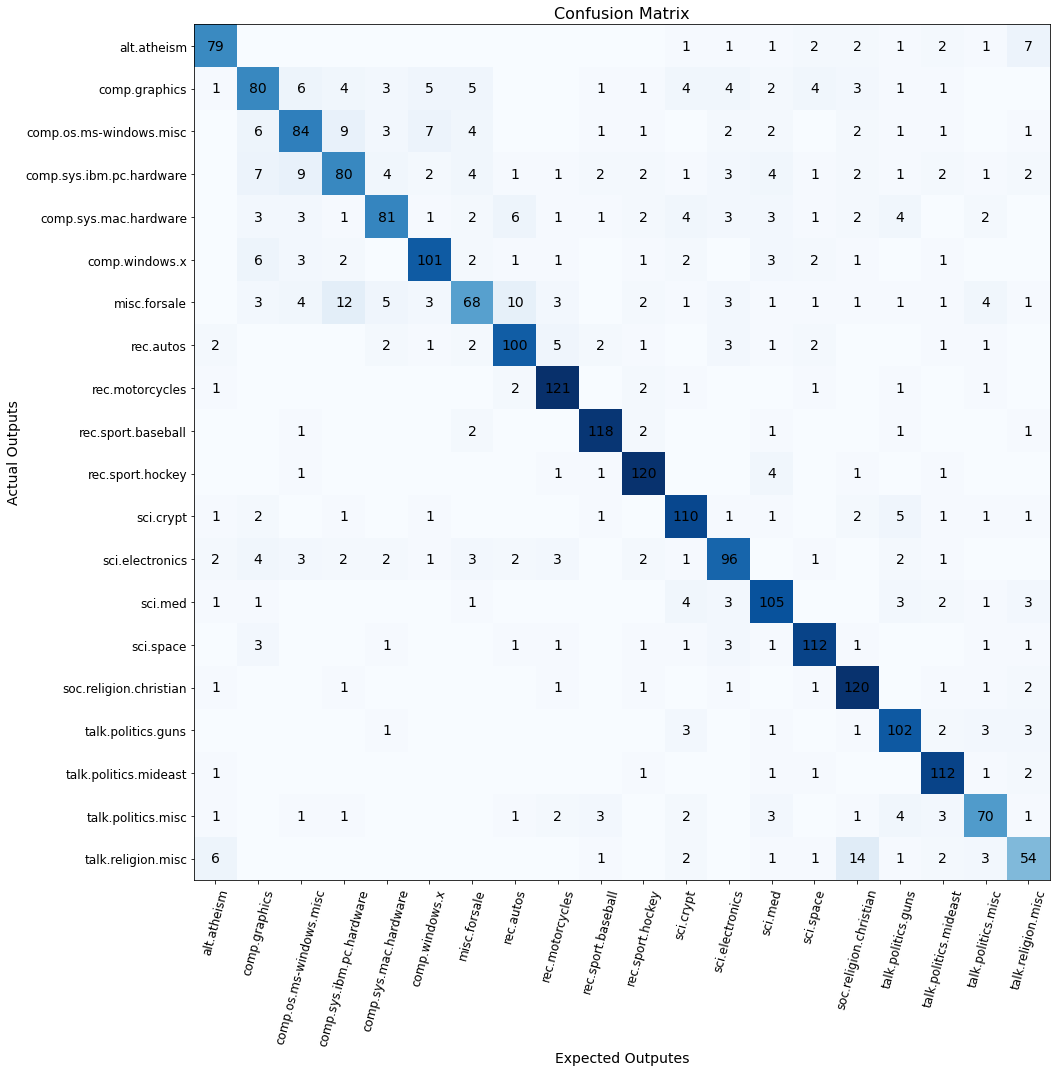



Eta: 0.005 	 Lambda: 0.0001

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



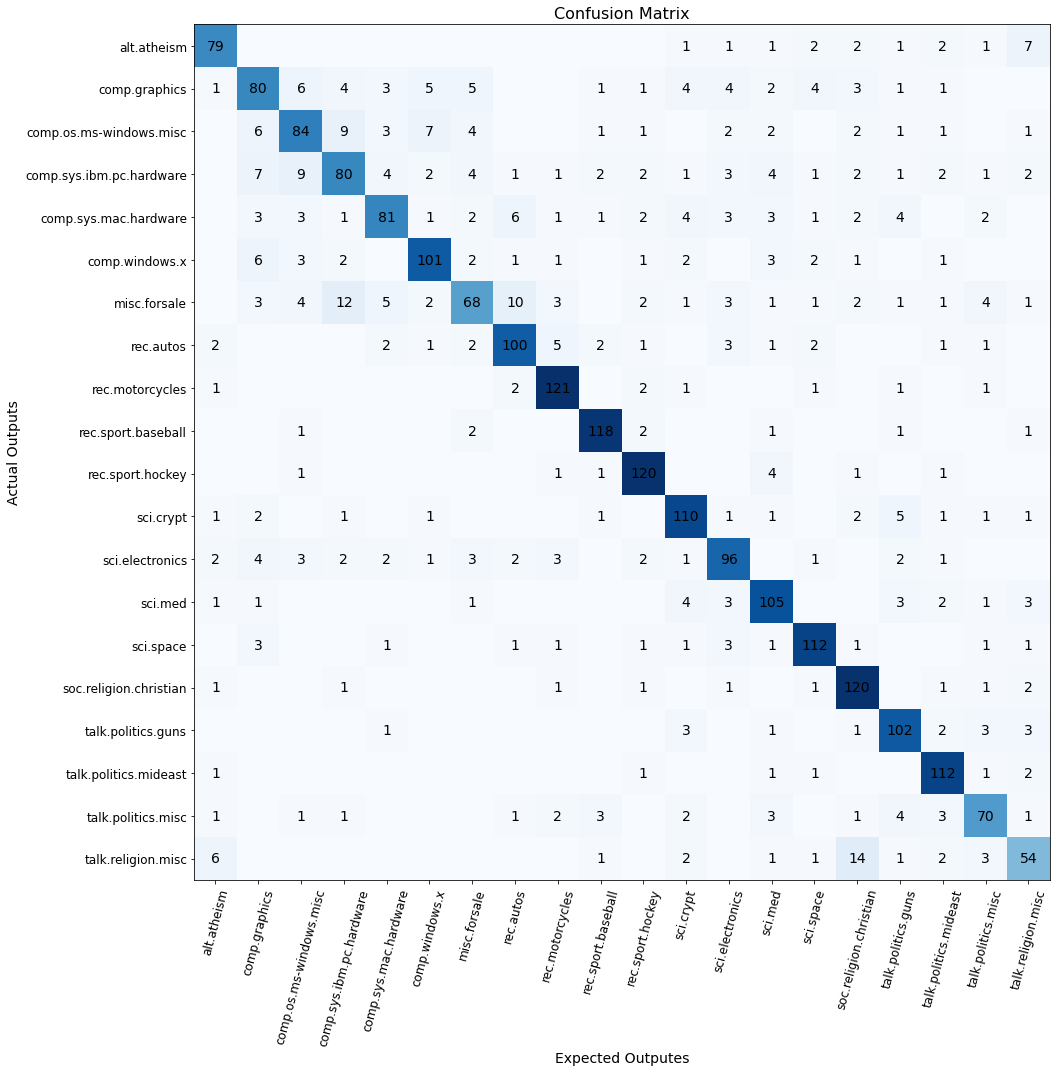



Eta: 0.005 	 Lambda: 0.0005

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



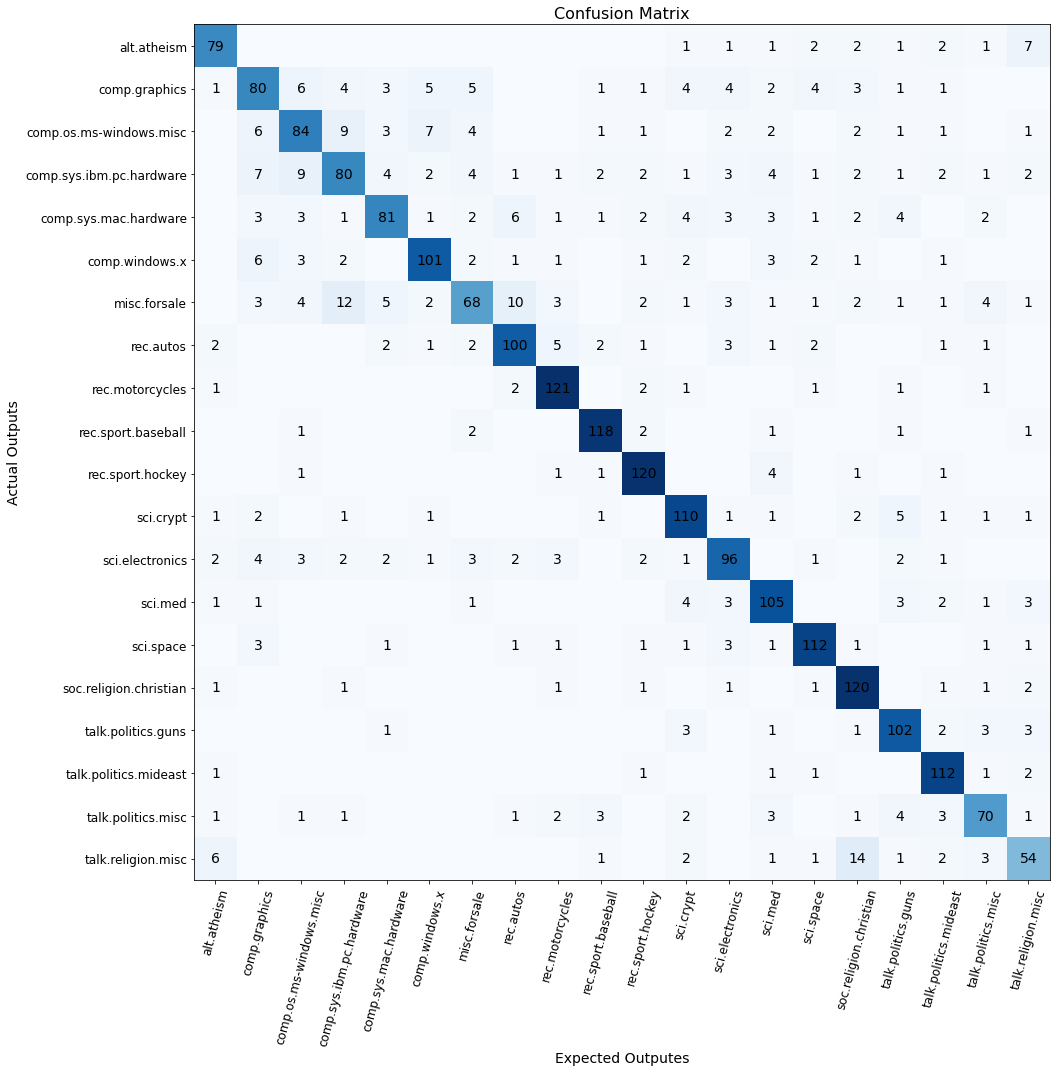



Eta: 0.005 	 Lambda: 0.001

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



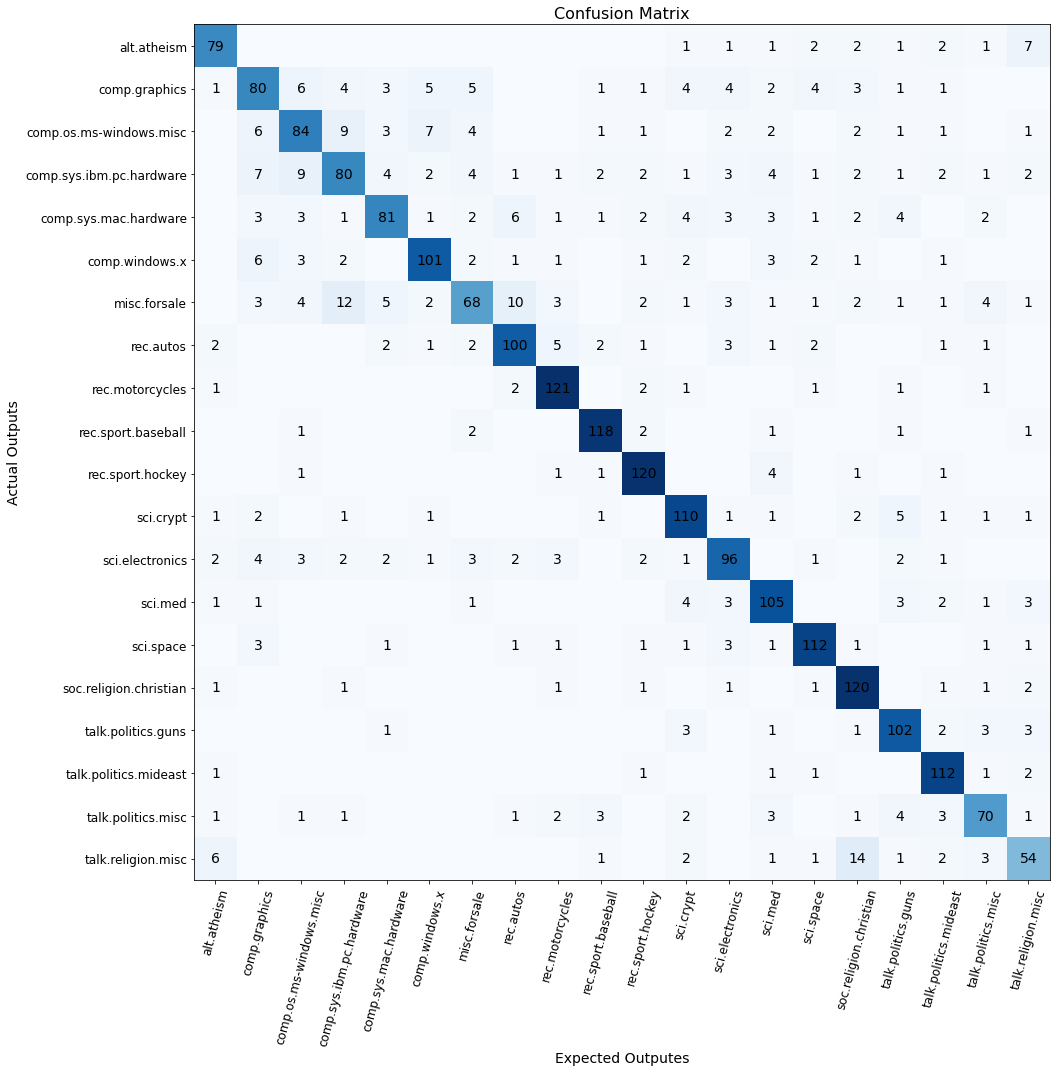



Eta: 0.005 	 Lambda: 0.005

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



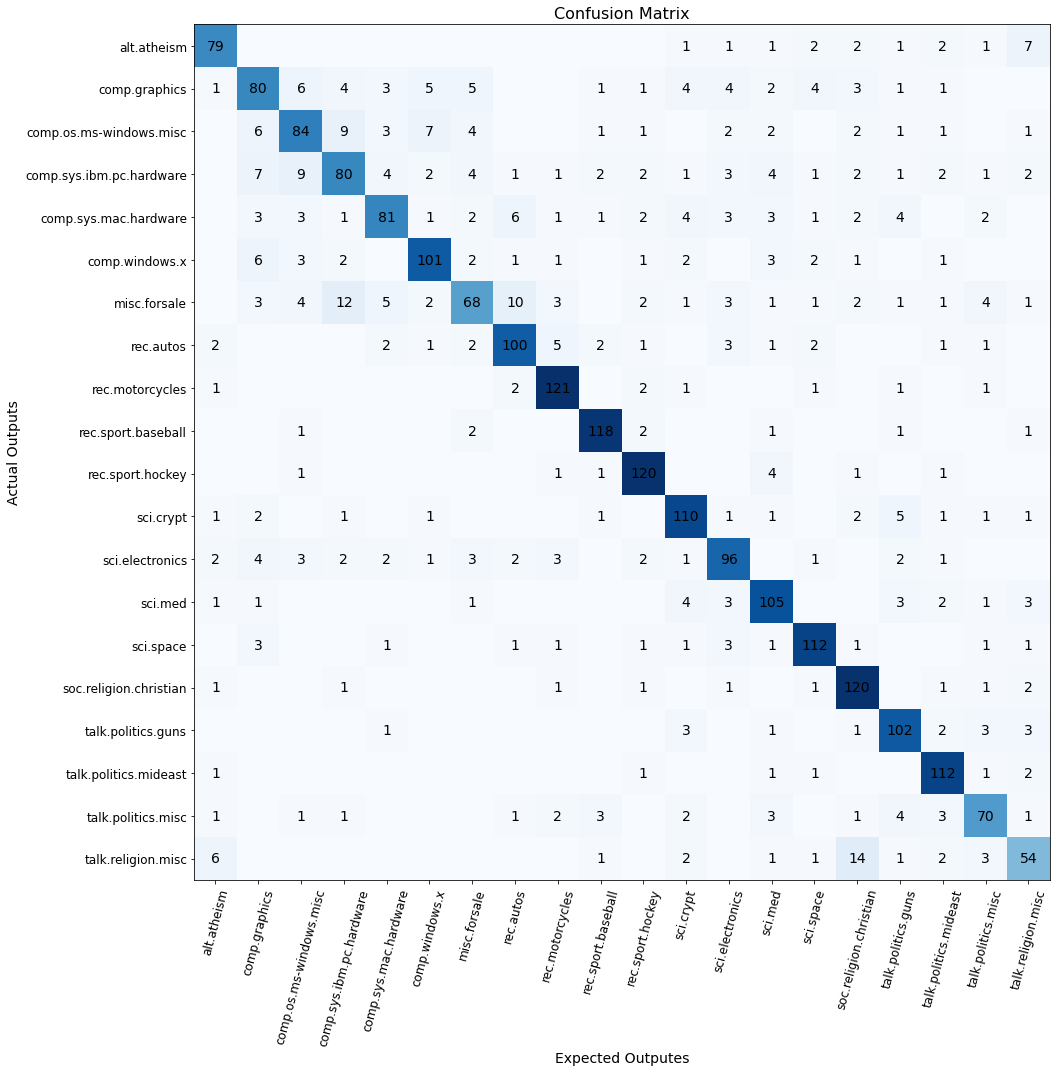



Eta: 0.005 	 Lambda: 0.01

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



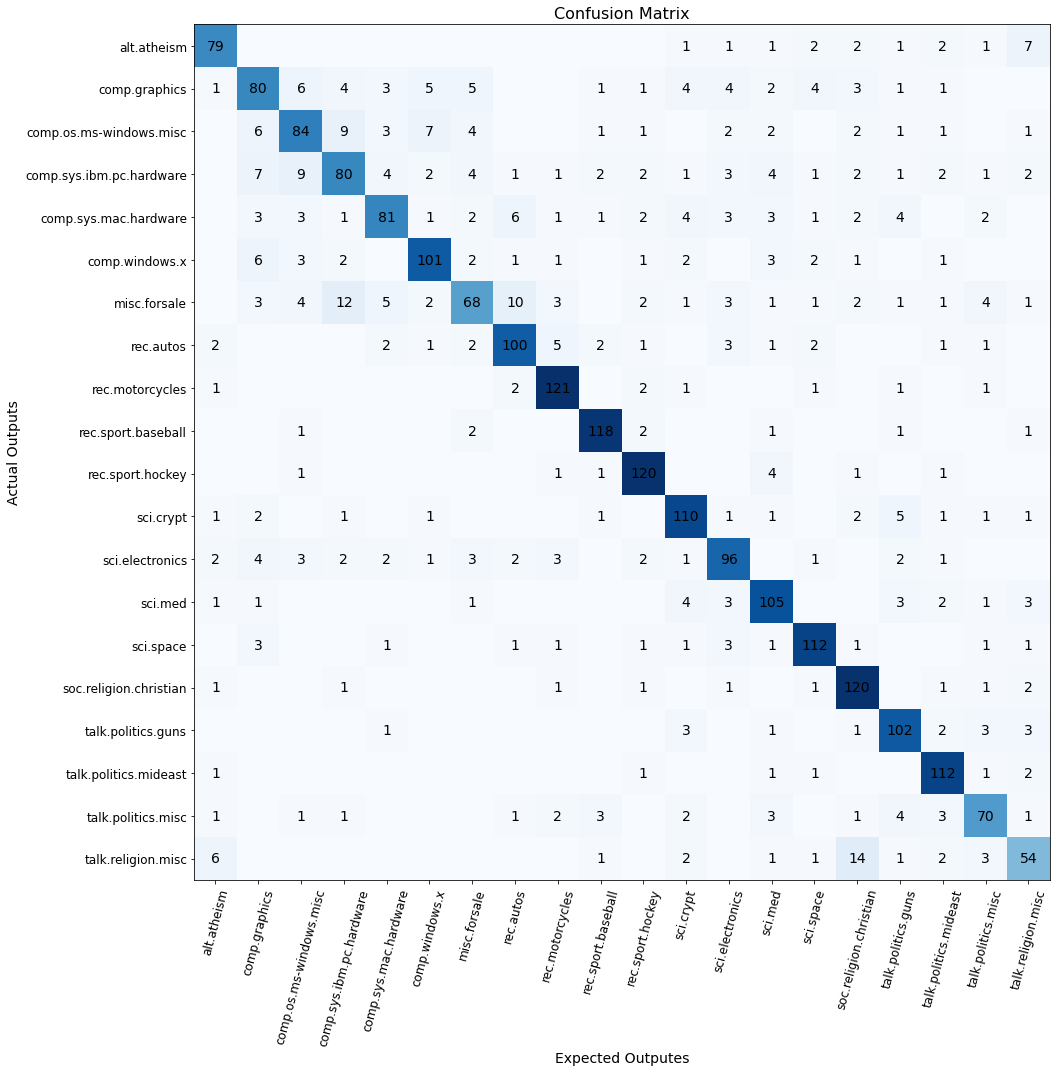



Eta: 0.005 	 Lambda: 0.05

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



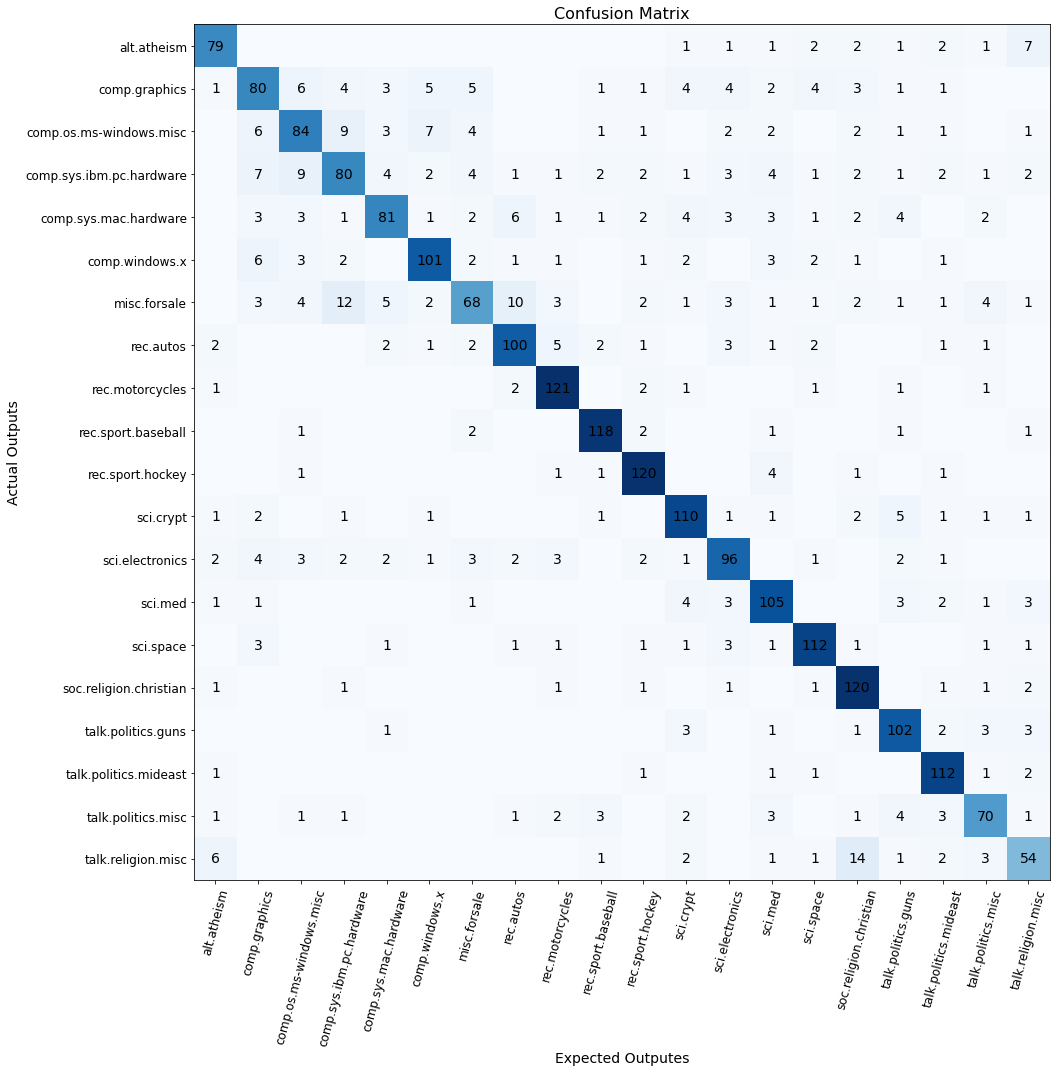



Eta: 0.005 	 Lambda: 0.1

 Accuracy: 0.7970833333333334

 Confusion Matrix: 



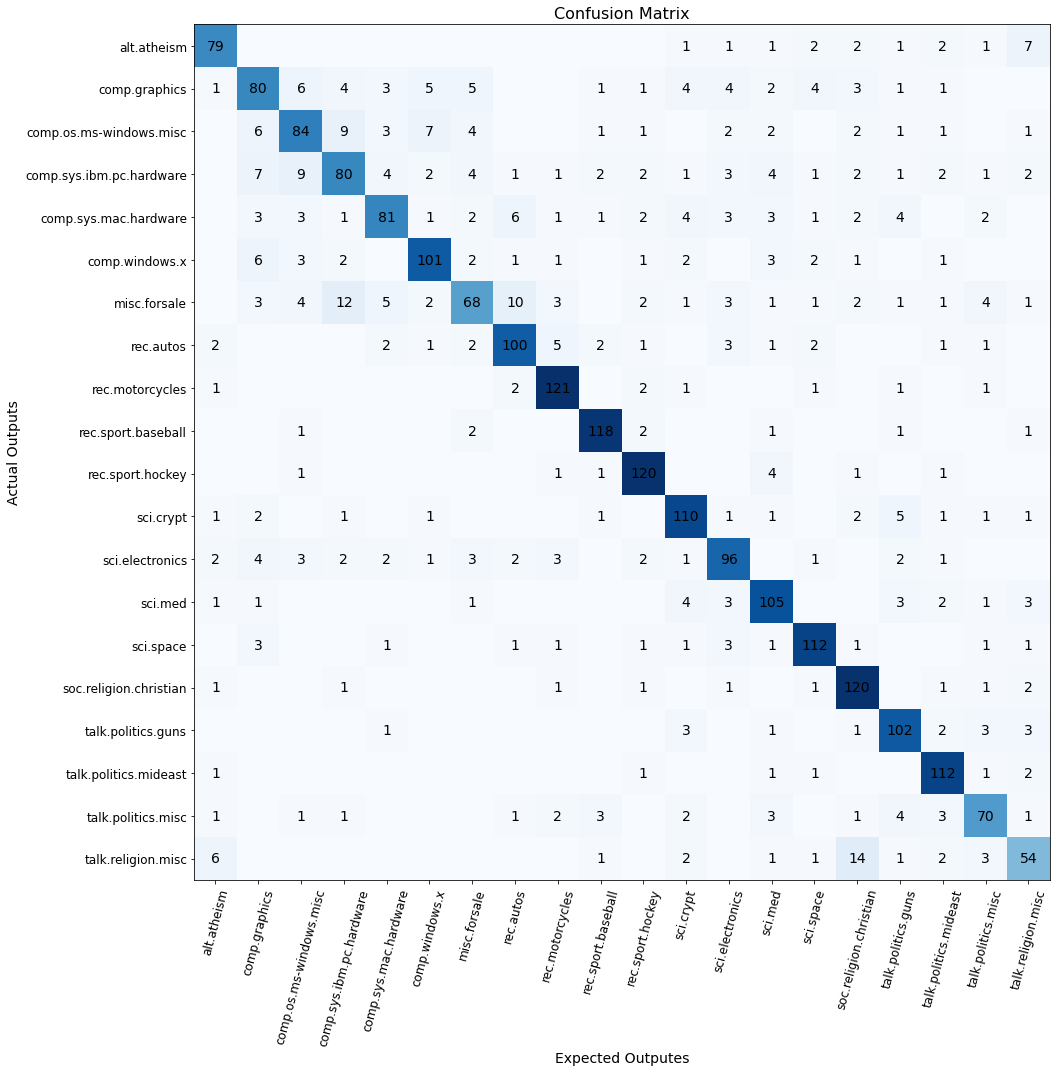



Eta: 0.01 	 Lambda: 0.0001

 Accuracy: 0.7979166666666667

 Confusion Matrix: 



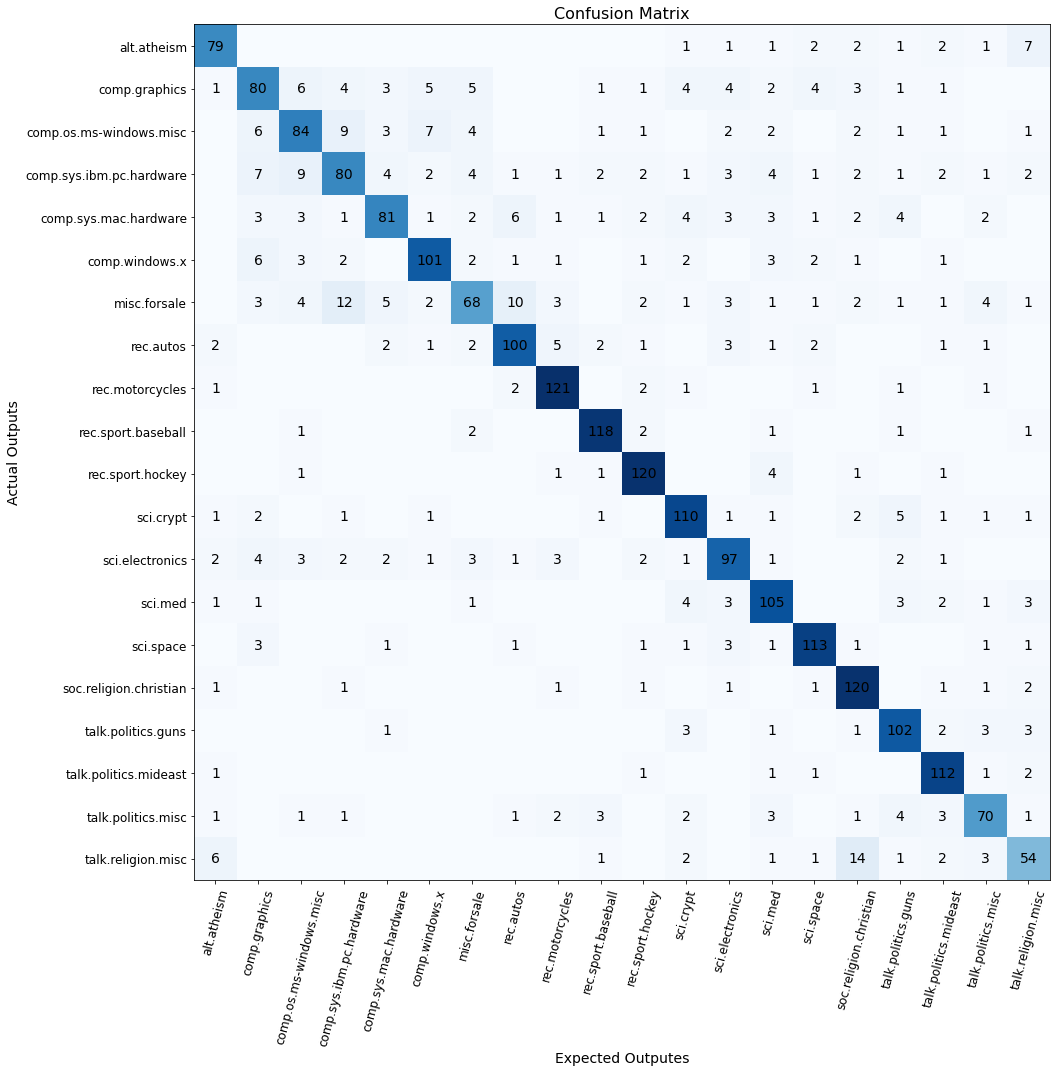



Eta: 0.01 	 Lambda: 0.0005

 Accuracy: 0.7979166666666667

 Confusion Matrix: 



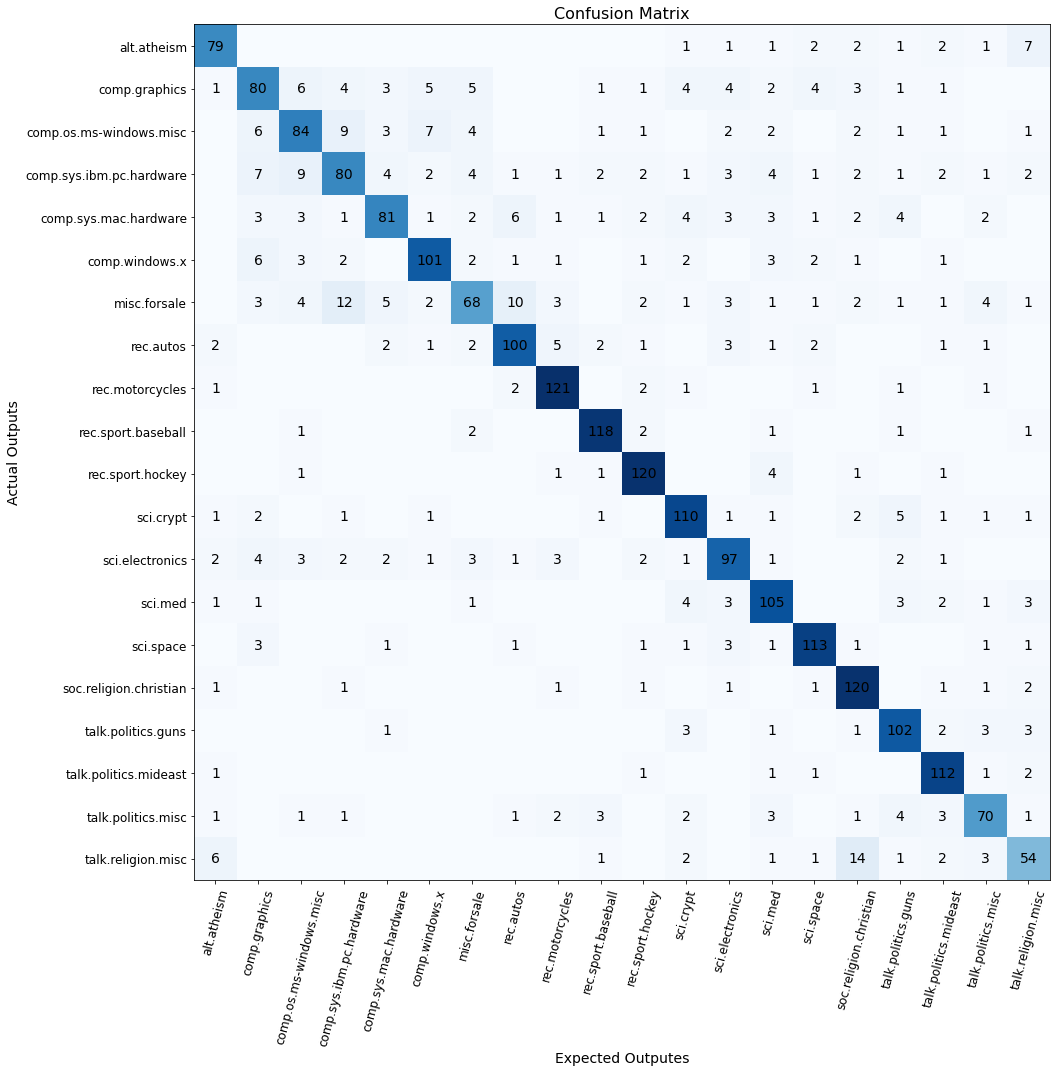



Eta: 0.01 	 Lambda: 0.001

 Accuracy: 0.7979166666666667

 Confusion Matrix: 



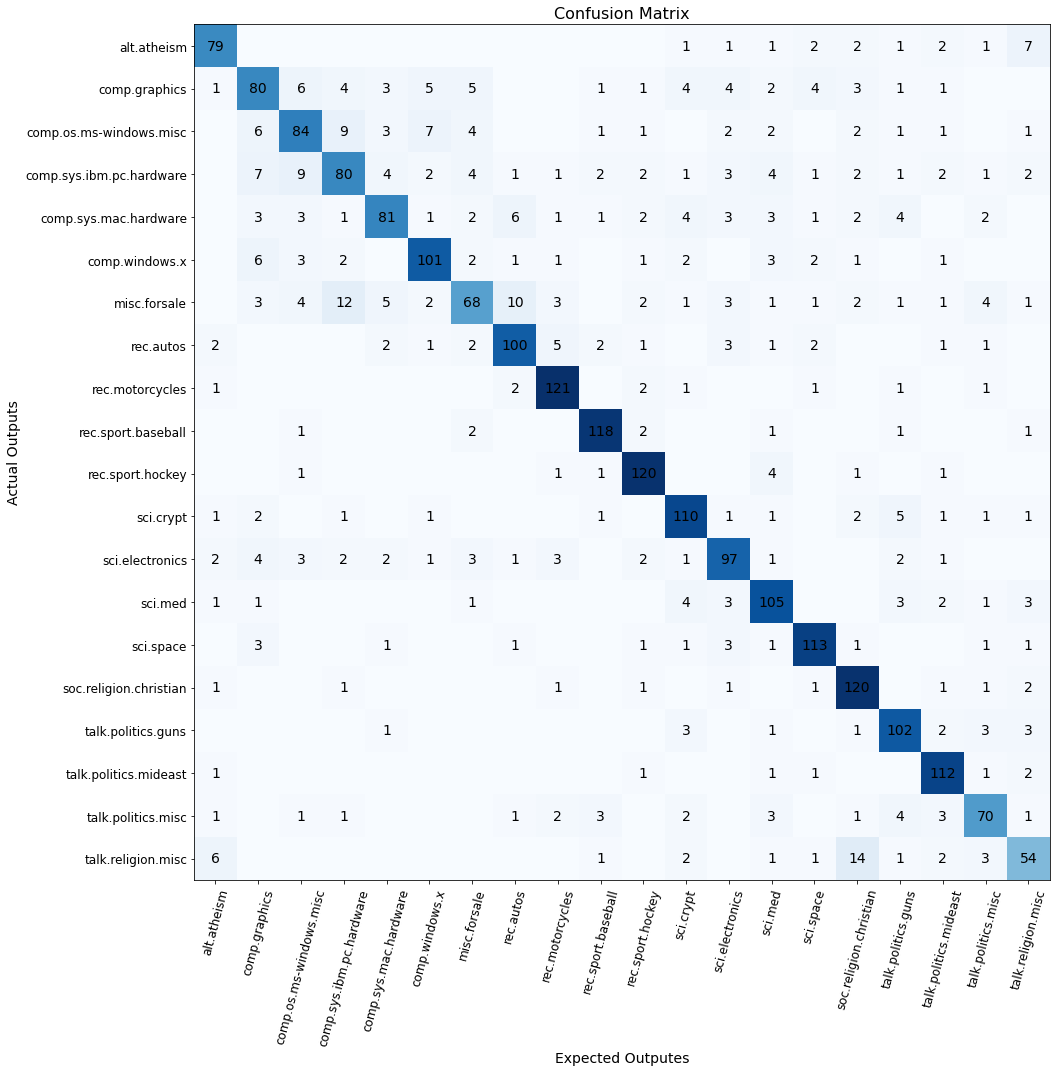



Eta: 0.01 	 Lambda: 0.005

 Accuracy: 0.7979166666666667

 Confusion Matrix: 



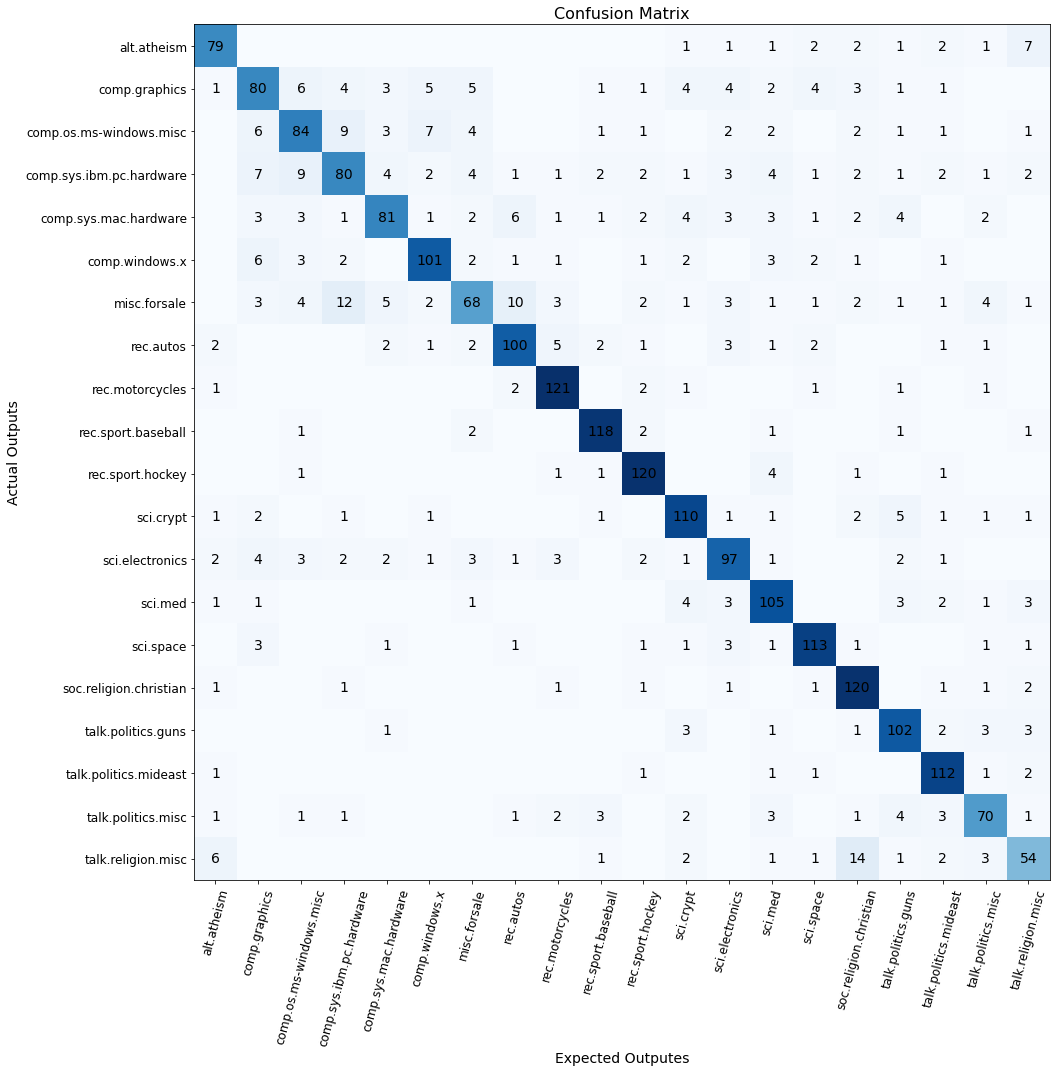



Eta: 0.01 	 Lambda: 0.01

 Accuracy: 0.7979166666666667

 Confusion Matrix: 



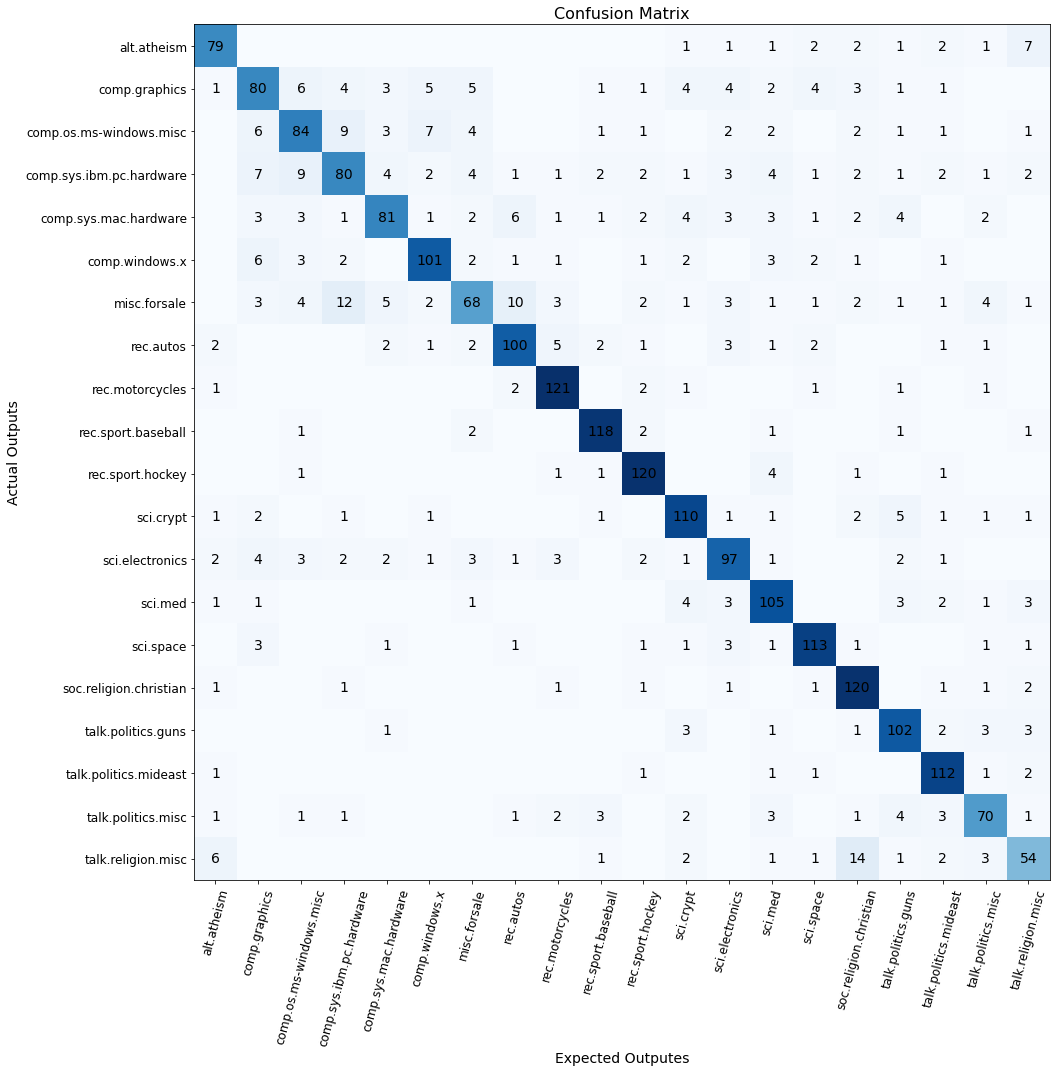



Eta: 0.01 	 Lambda: 0.05

 Accuracy: 0.7979166666666667

 Confusion Matrix: 



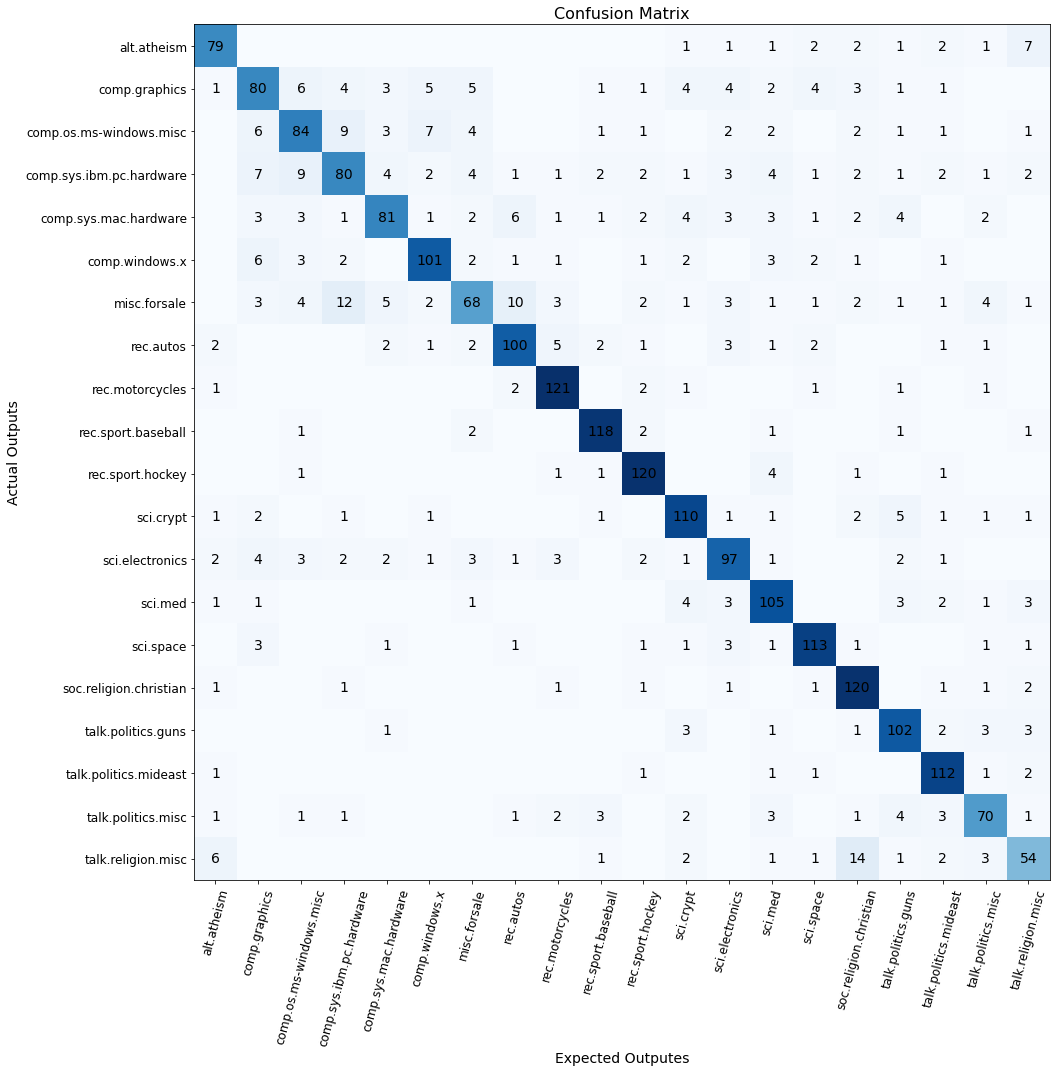



Eta: 0.01 	 Lambda: 0.1

 Accuracy: 0.7979166666666667

 Confusion Matrix: 



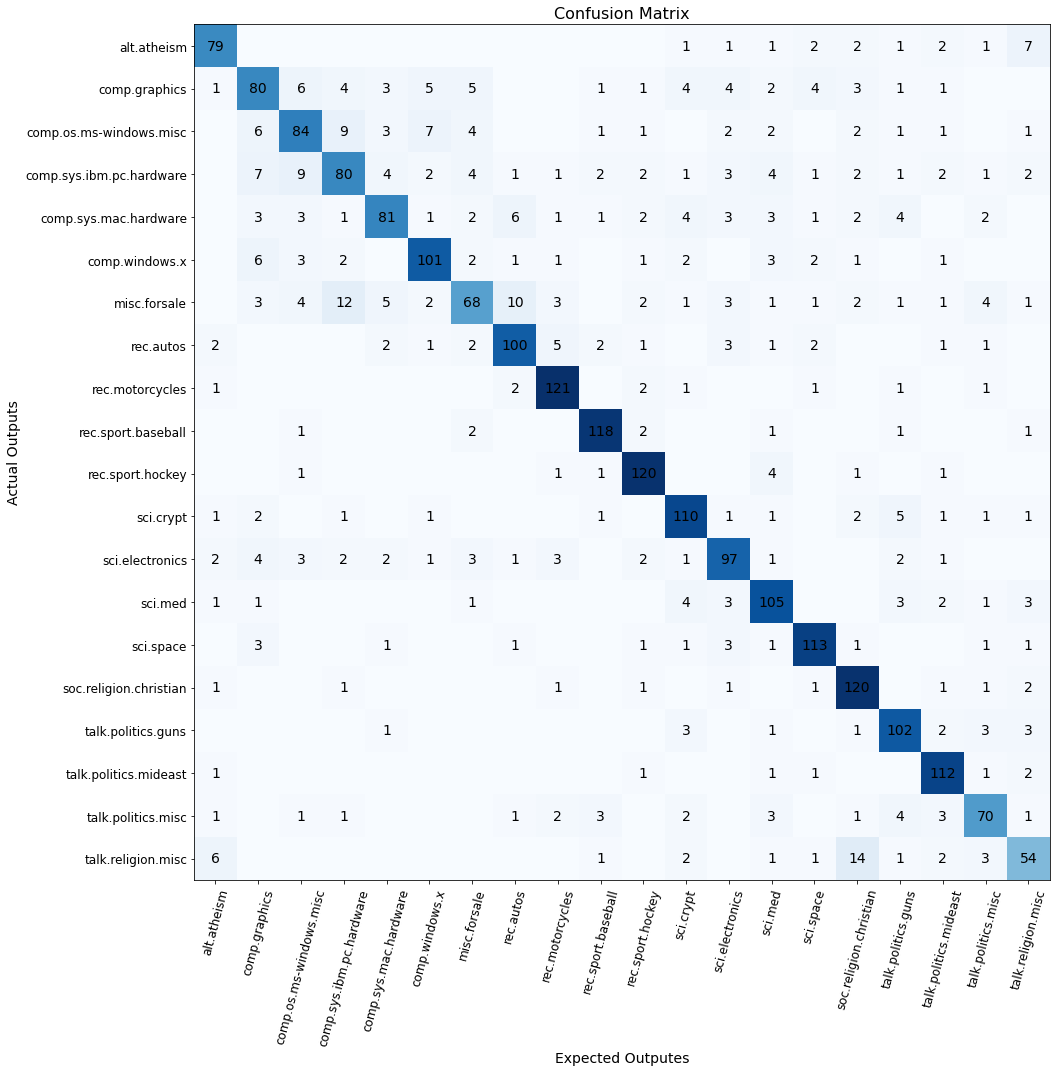



Eta: 0.05 	 Lambda: 0.0001

 Accuracy: 0.8004166666666667

 Confusion Matrix: 



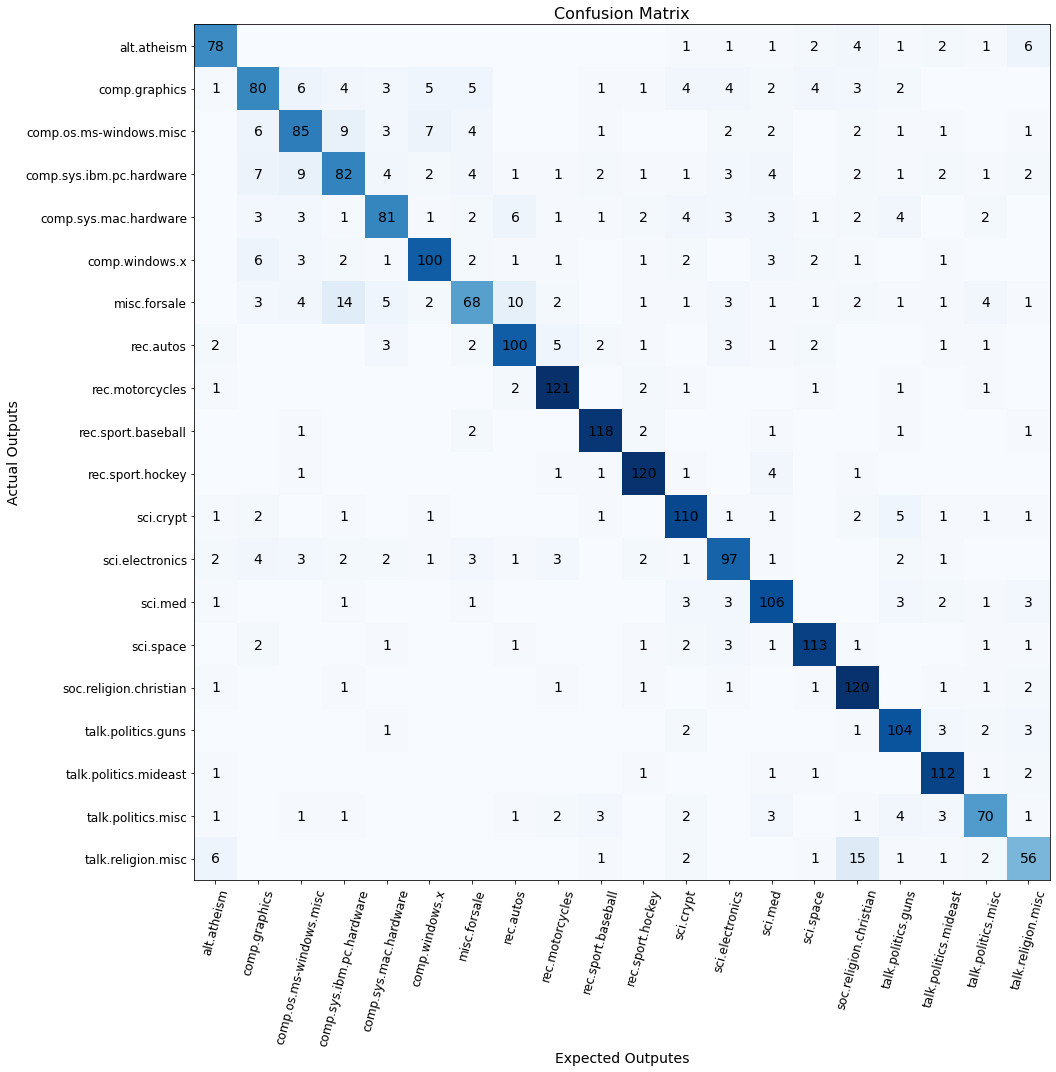



Eta: 0.05 	 Lambda: 0.0005

 Accuracy: 0.8004166666666667

 Confusion Matrix: 



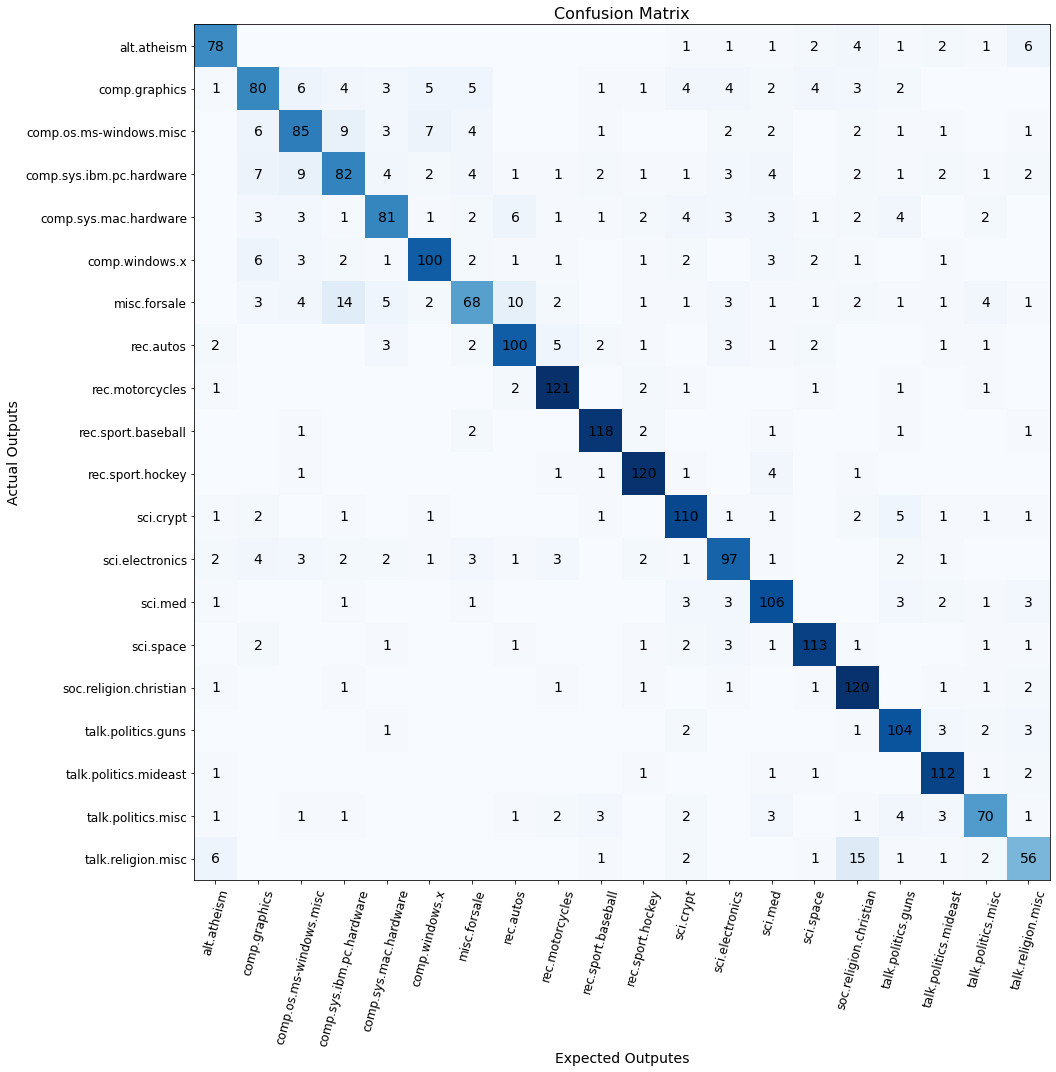



Eta: 0.05 	 Lambda: 0.001

 Accuracy: 0.8004166666666667

 Confusion Matrix: 



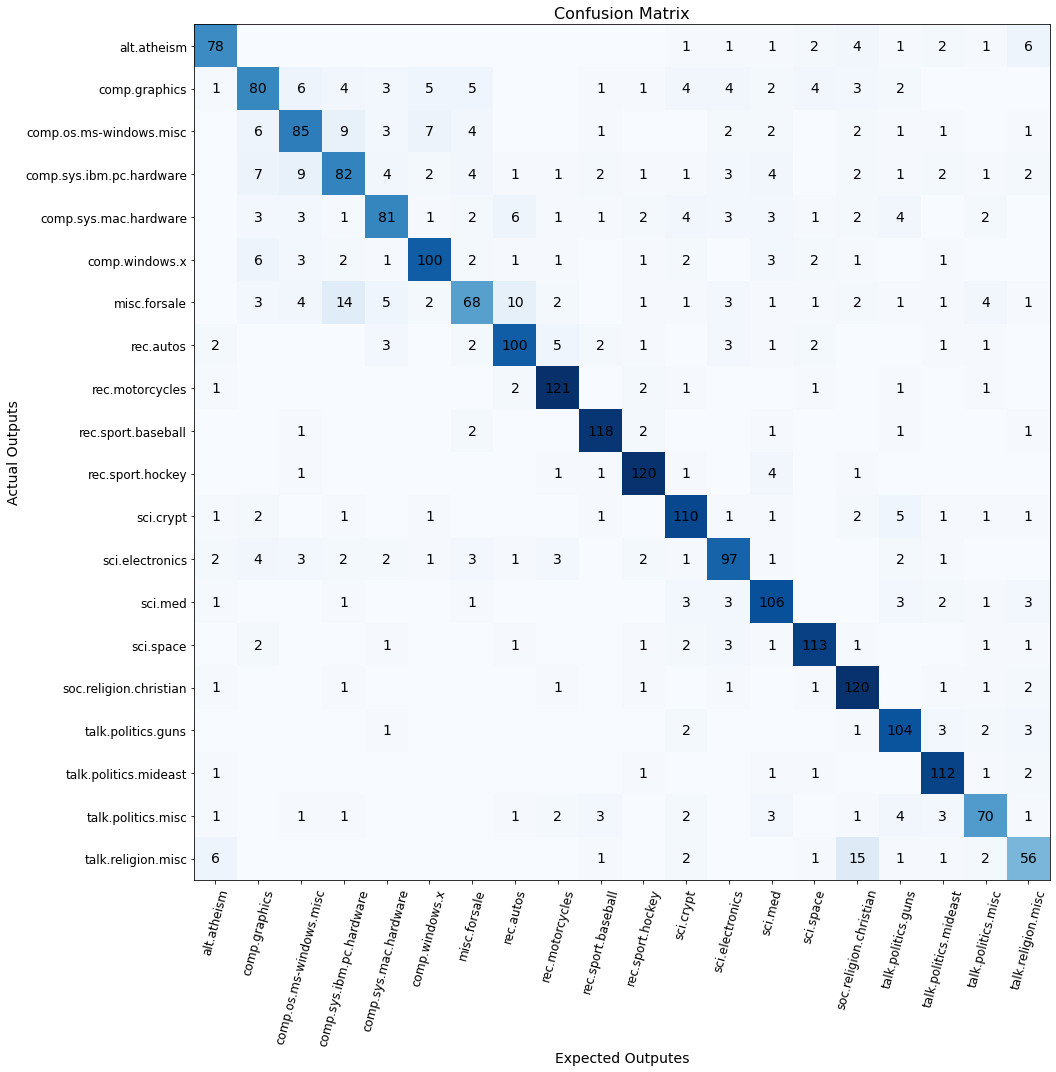



Eta: 0.05 	 Lambda: 0.005

 Accuracy: 0.8004166666666667

 Confusion Matrix: 



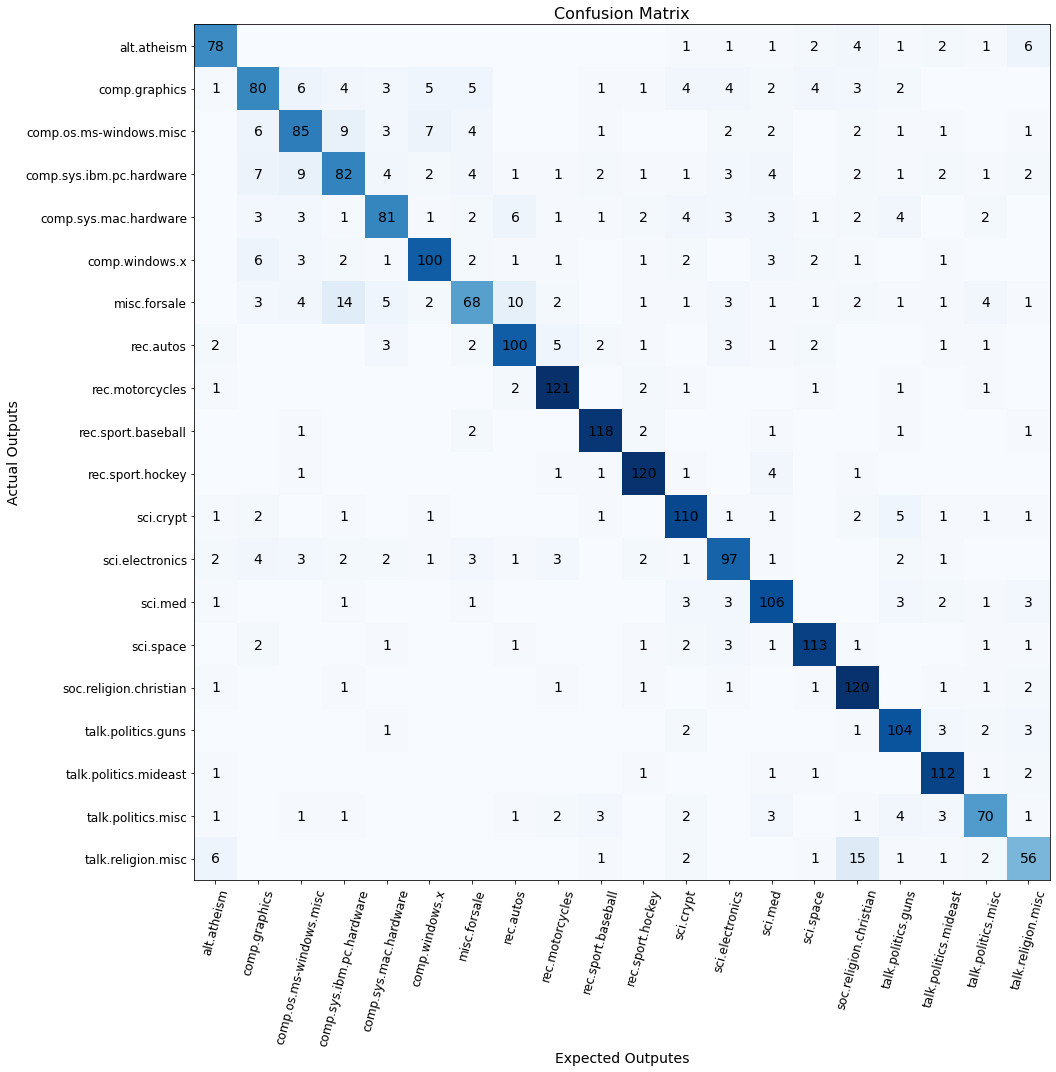



Eta: 0.05 	 Lambda: 0.01

 Accuracy: 0.8004166666666667

 Confusion Matrix: 



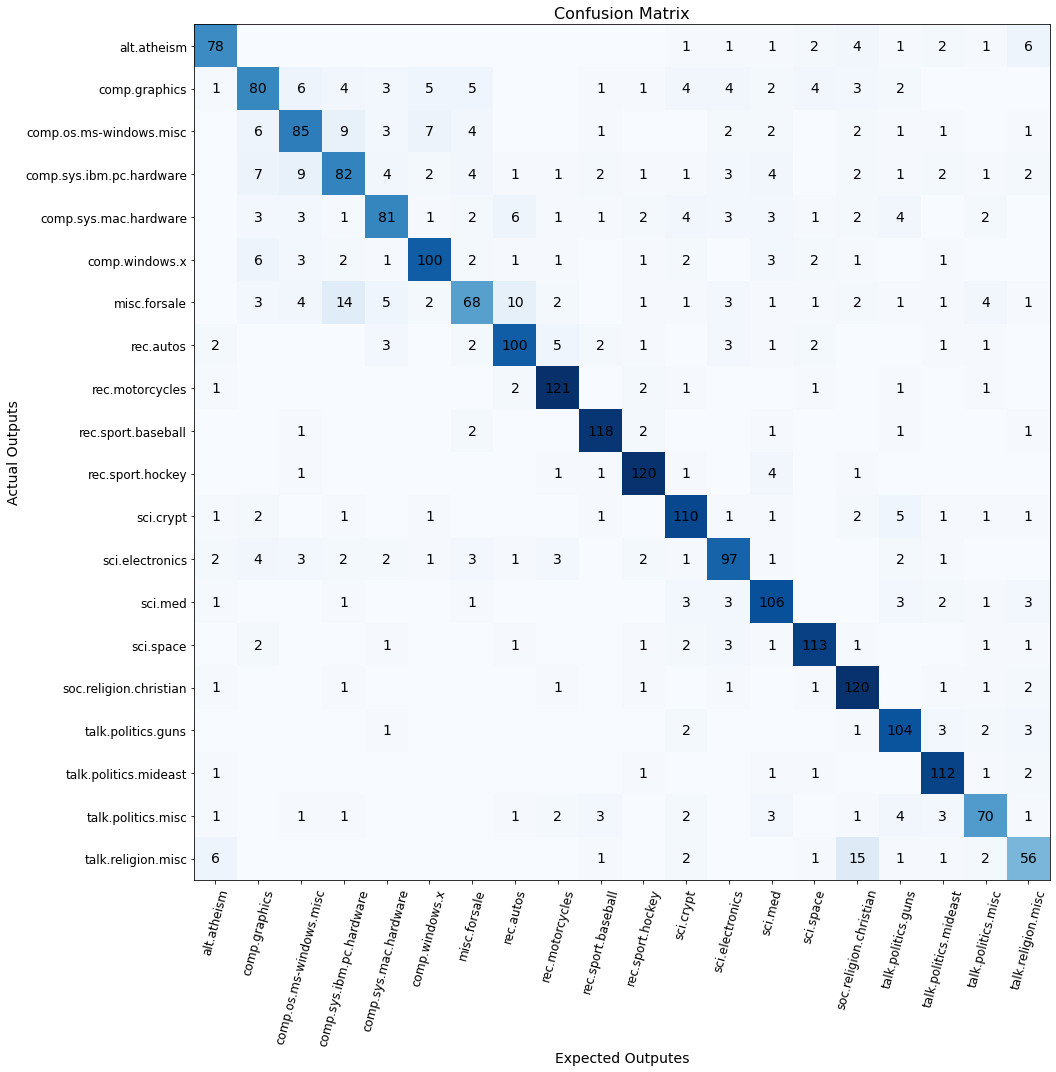



Eta: 0.05 	 Lambda: 0.05

 Accuracy: 0.8004166666666667

 Confusion Matrix: 



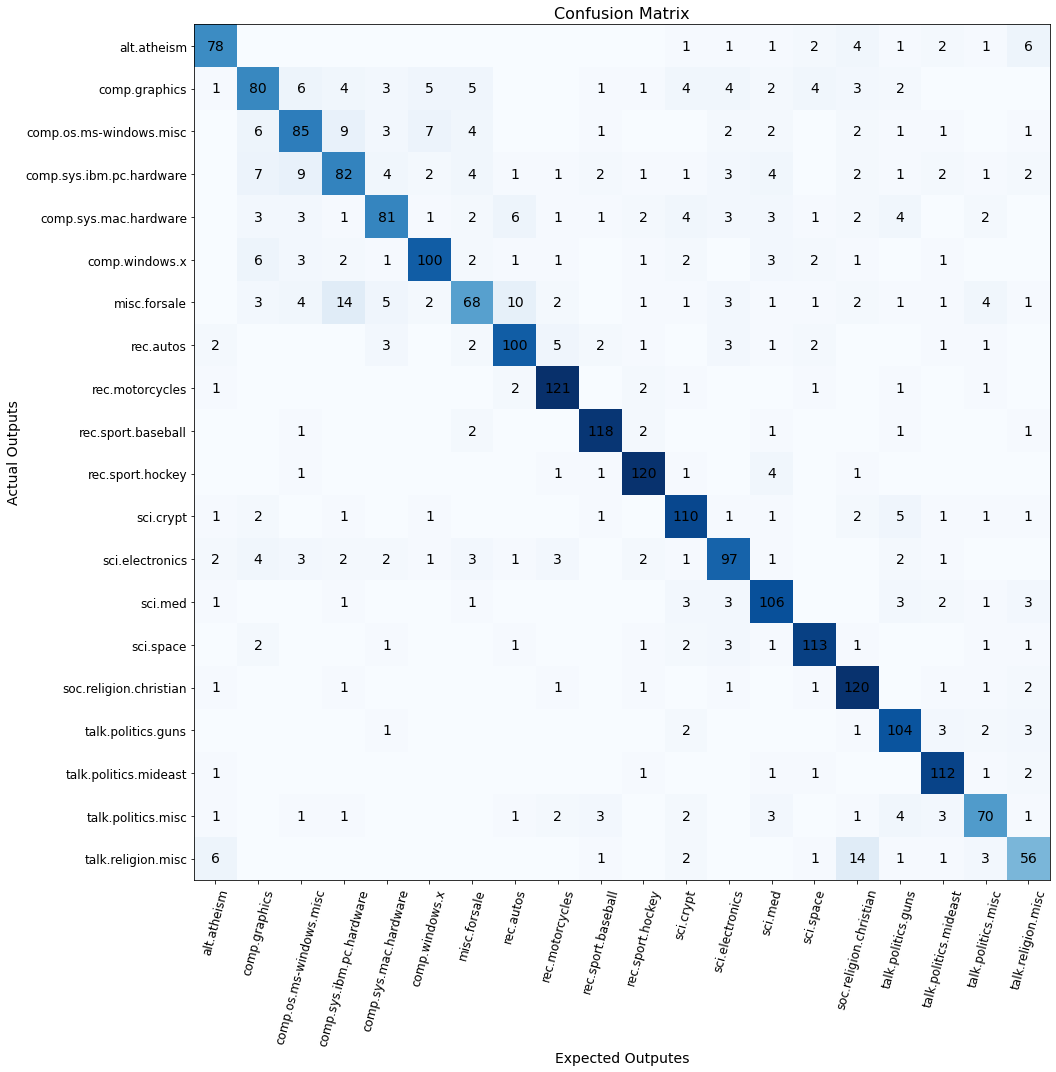



Eta: 0.05 	 Lambda: 0.1

 Accuracy: 0.8004166666666667

 Confusion Matrix: 



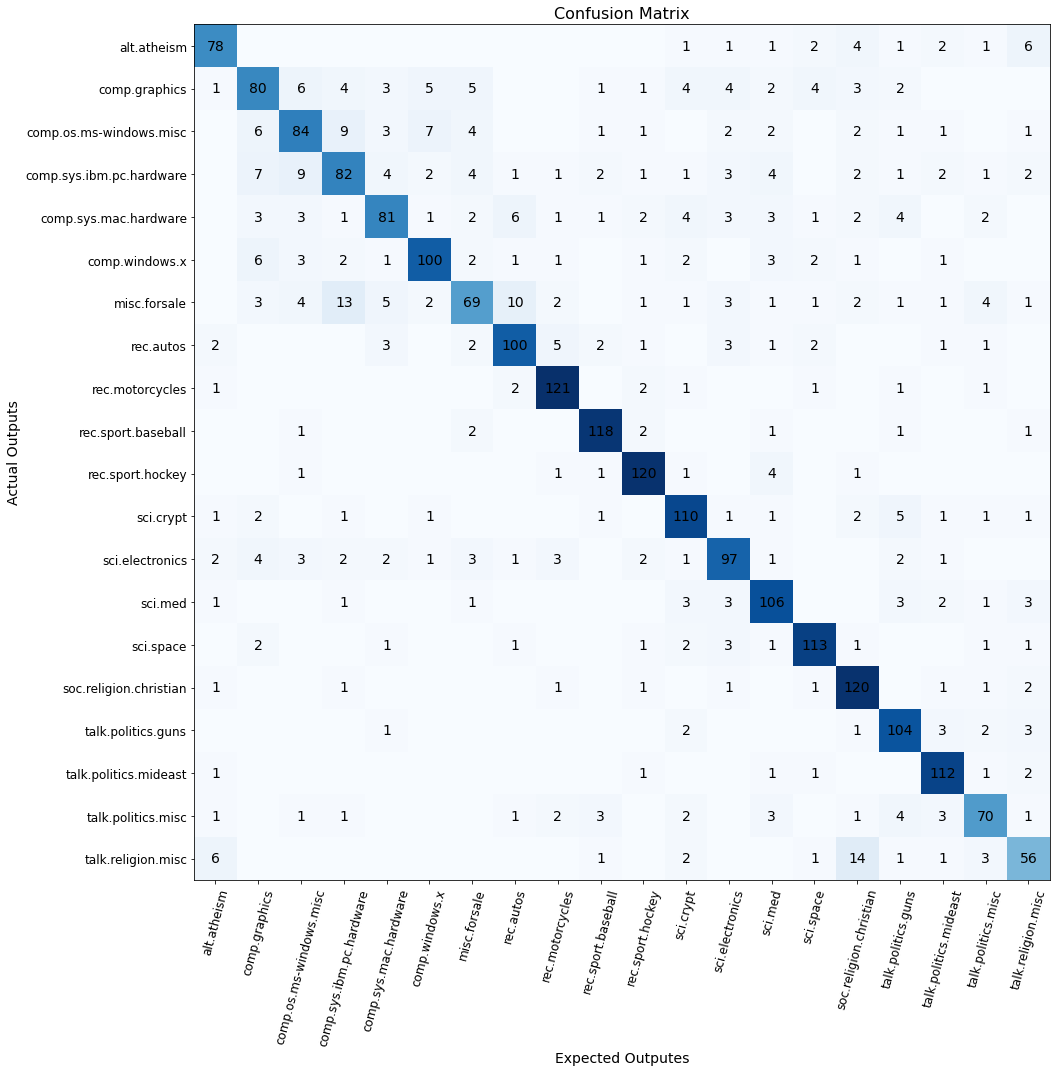



Eta: 0.1 	 Lambda: 0.0001

 Accuracy: 0.8016666666666666

 Confusion Matrix: 



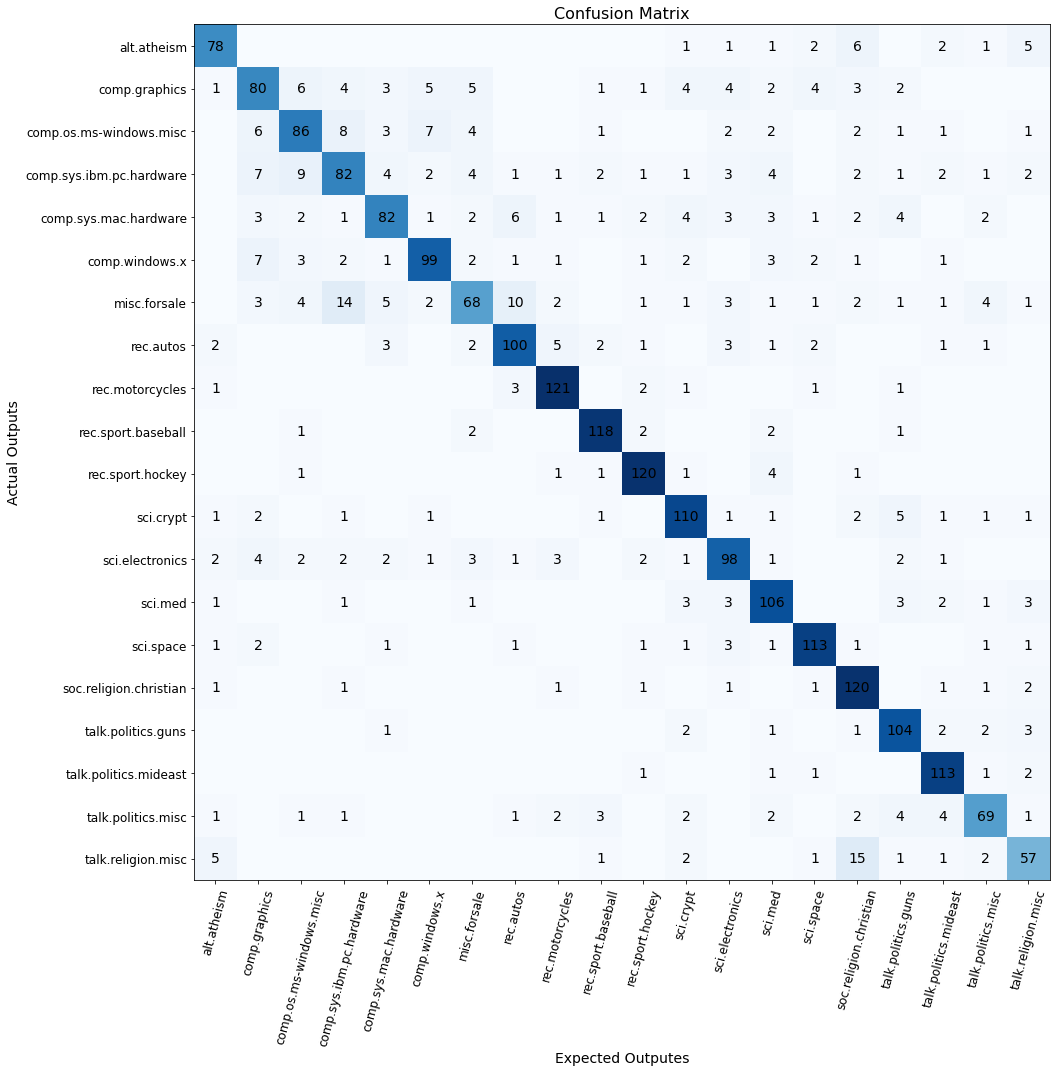



Eta: 0.1 	 Lambda: 0.0005

 Accuracy: 0.8016666666666666

 Confusion Matrix: 



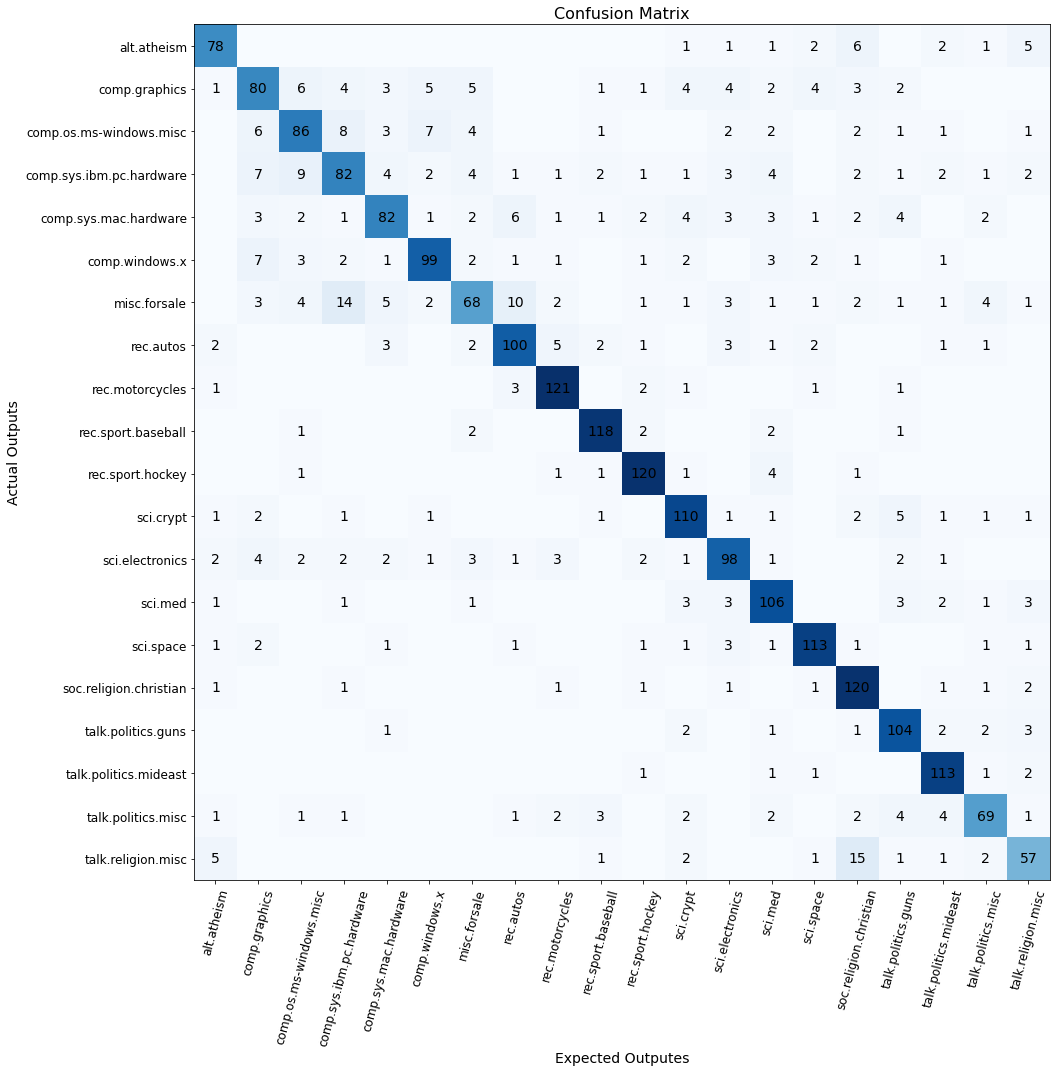



Eta: 0.1 	 Lambda: 0.001

 Accuracy: 0.8016666666666666

 Confusion Matrix: 



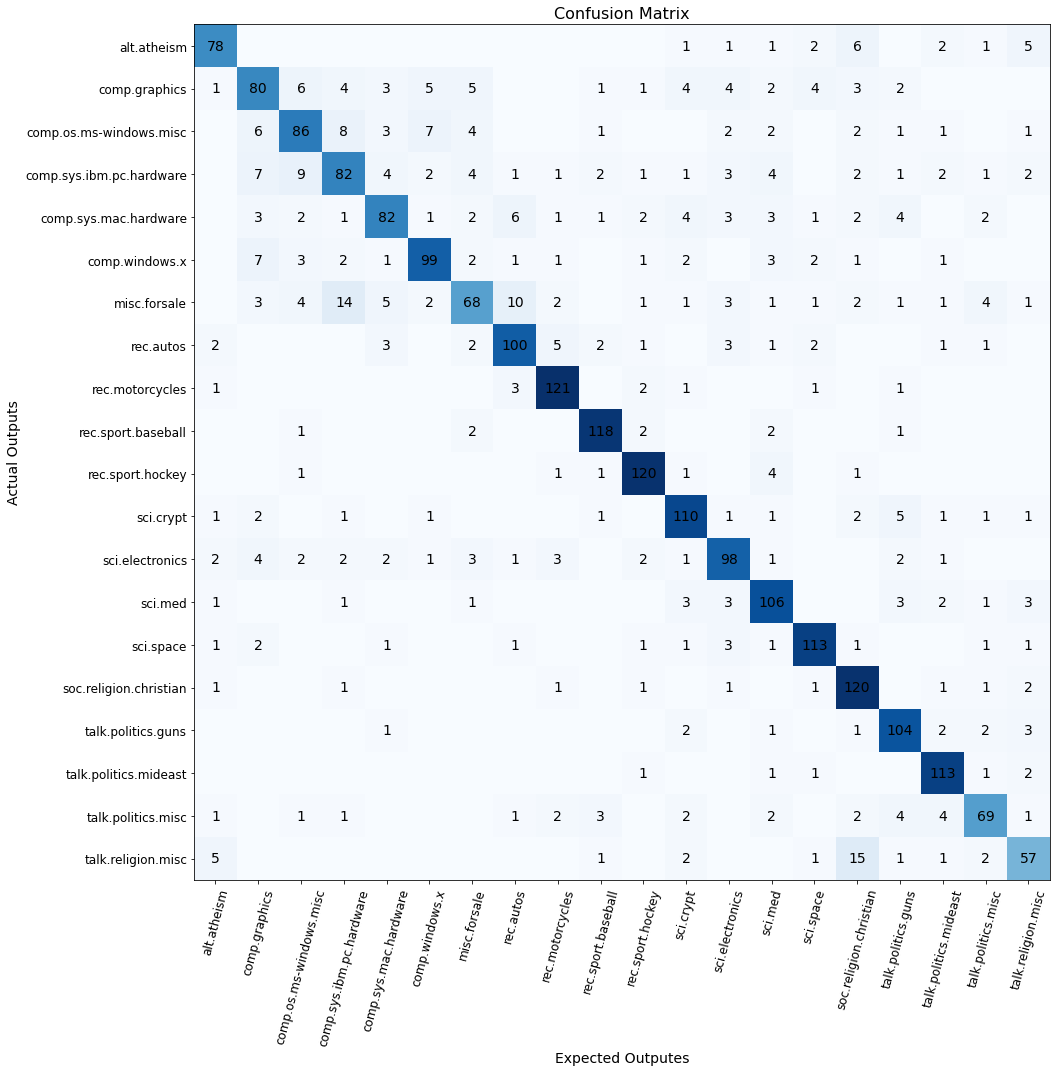



Eta: 0.1 	 Lambda: 0.005

 Accuracy: 0.8016666666666666

 Confusion Matrix: 



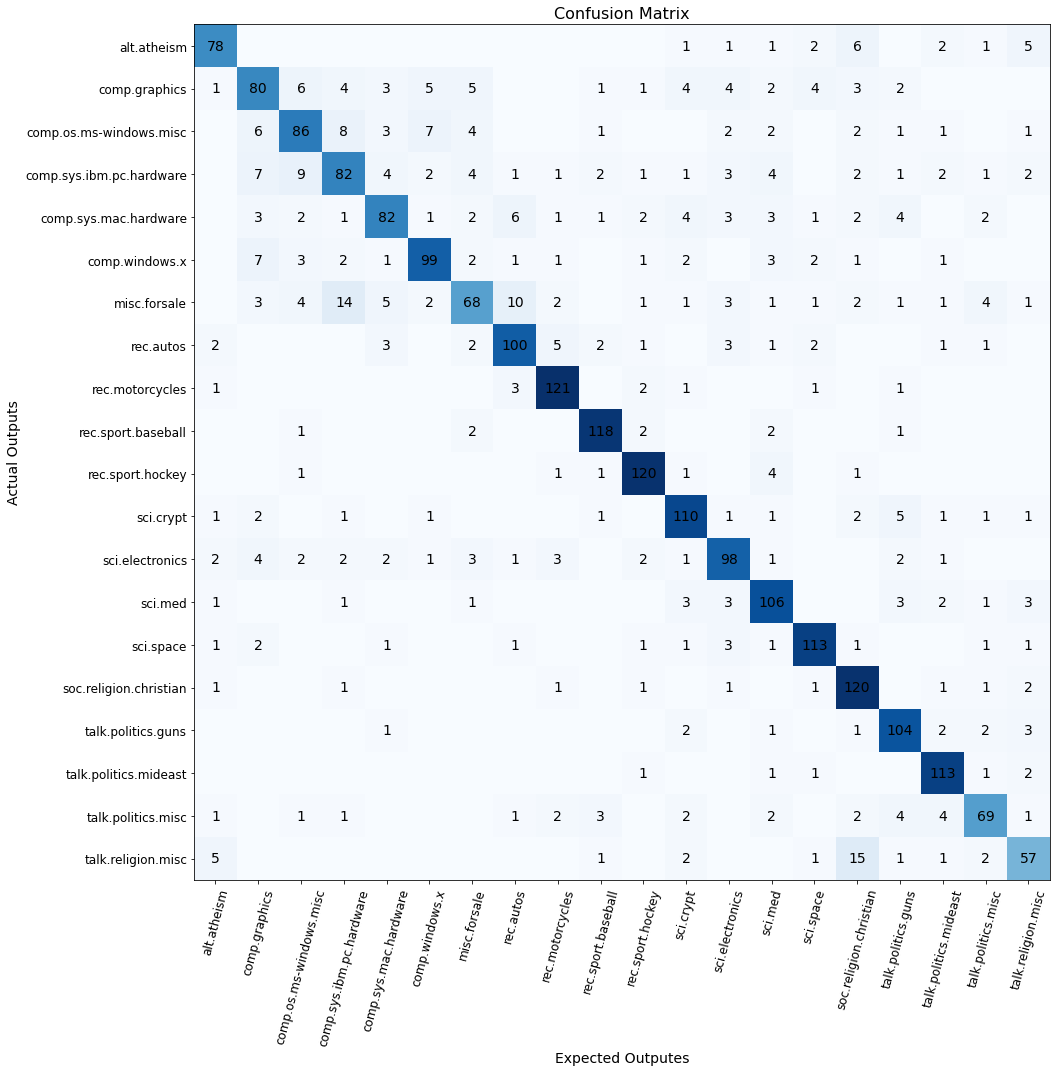



Eta: 0.1 	 Lambda: 0.01

 Accuracy: 0.8016666666666666

 Confusion Matrix: 



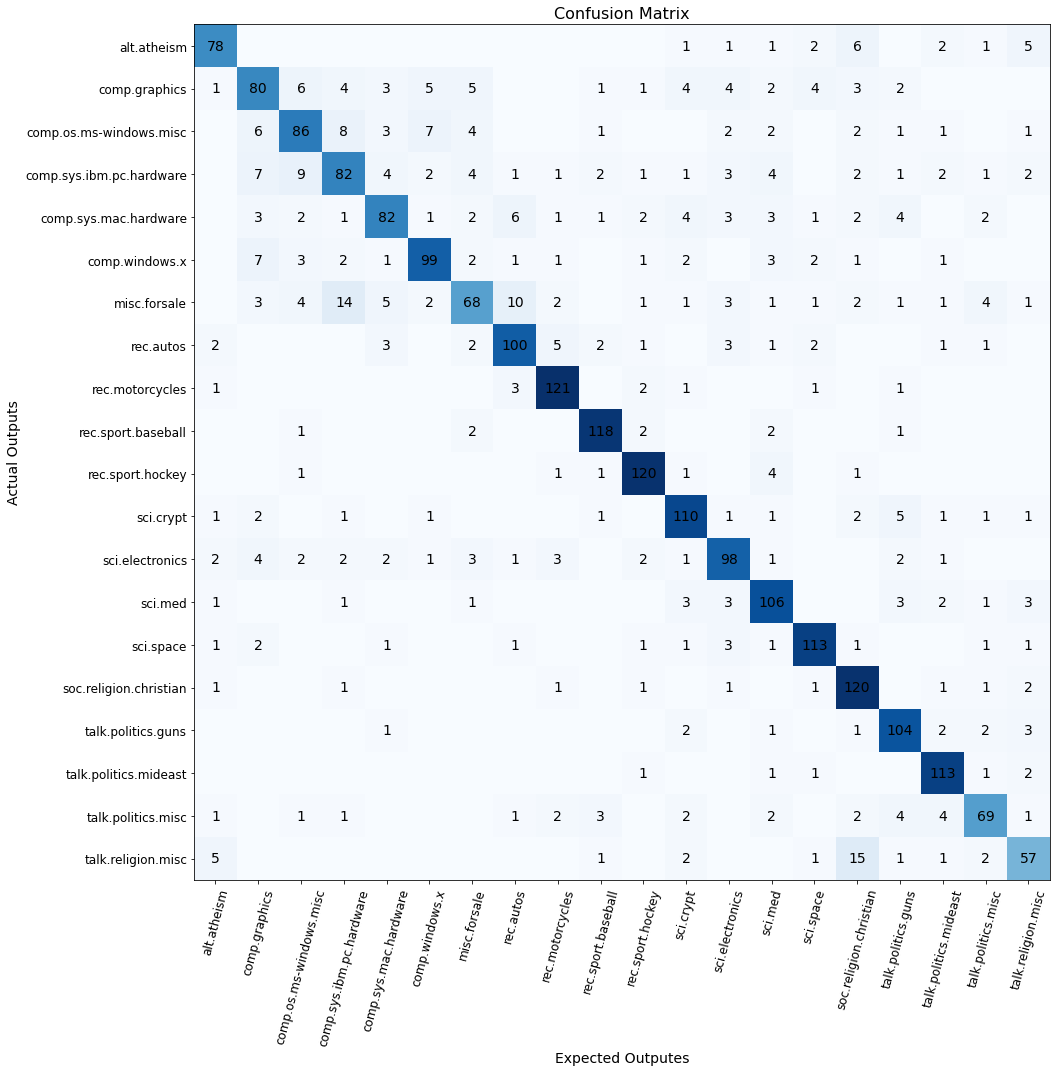



Eta: 0.1 	 Lambda: 0.05

 Accuracy: 0.8016666666666666

 Confusion Matrix: 



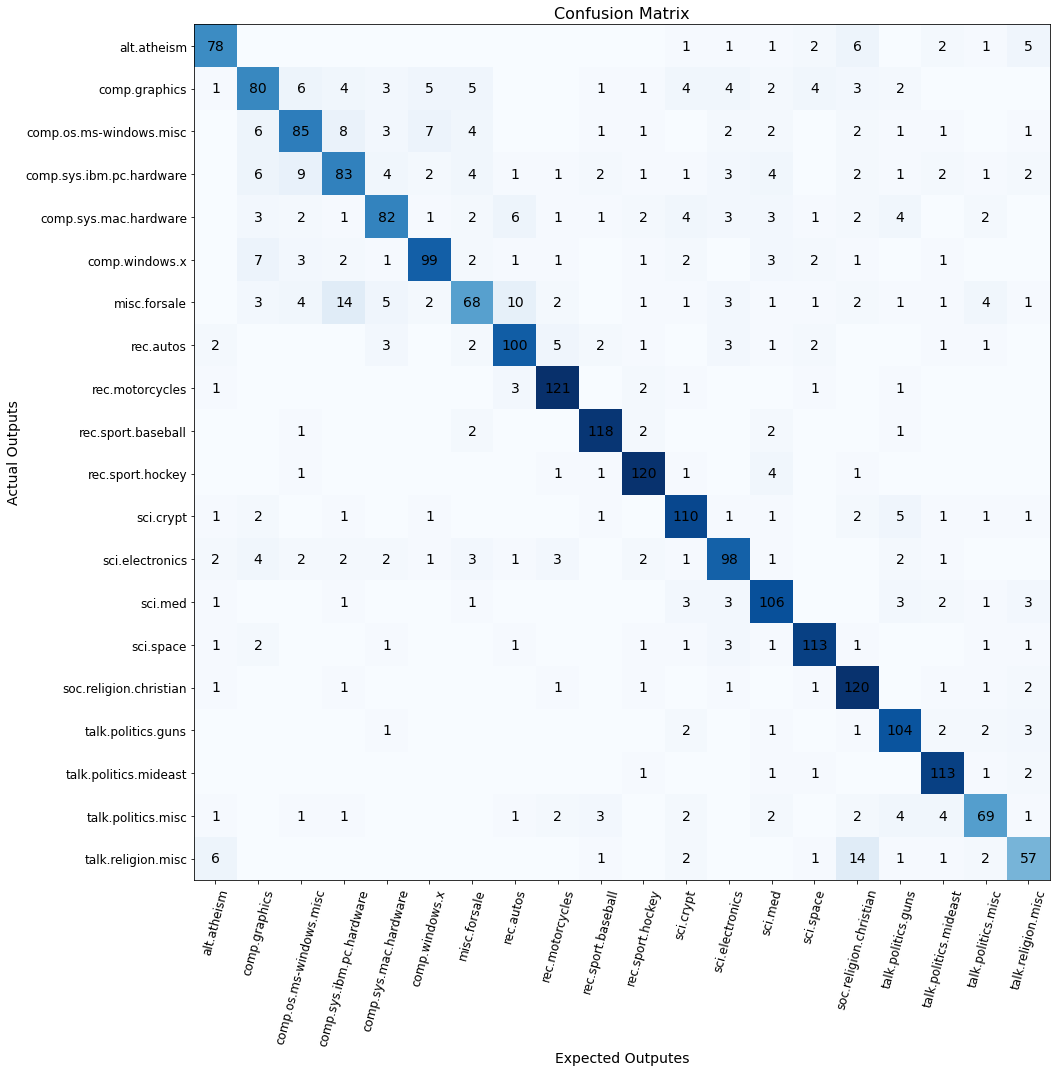



Eta: 0.1 	 Lambda: 0.1

 Accuracy: 0.8016666666666666

 Confusion Matrix: 



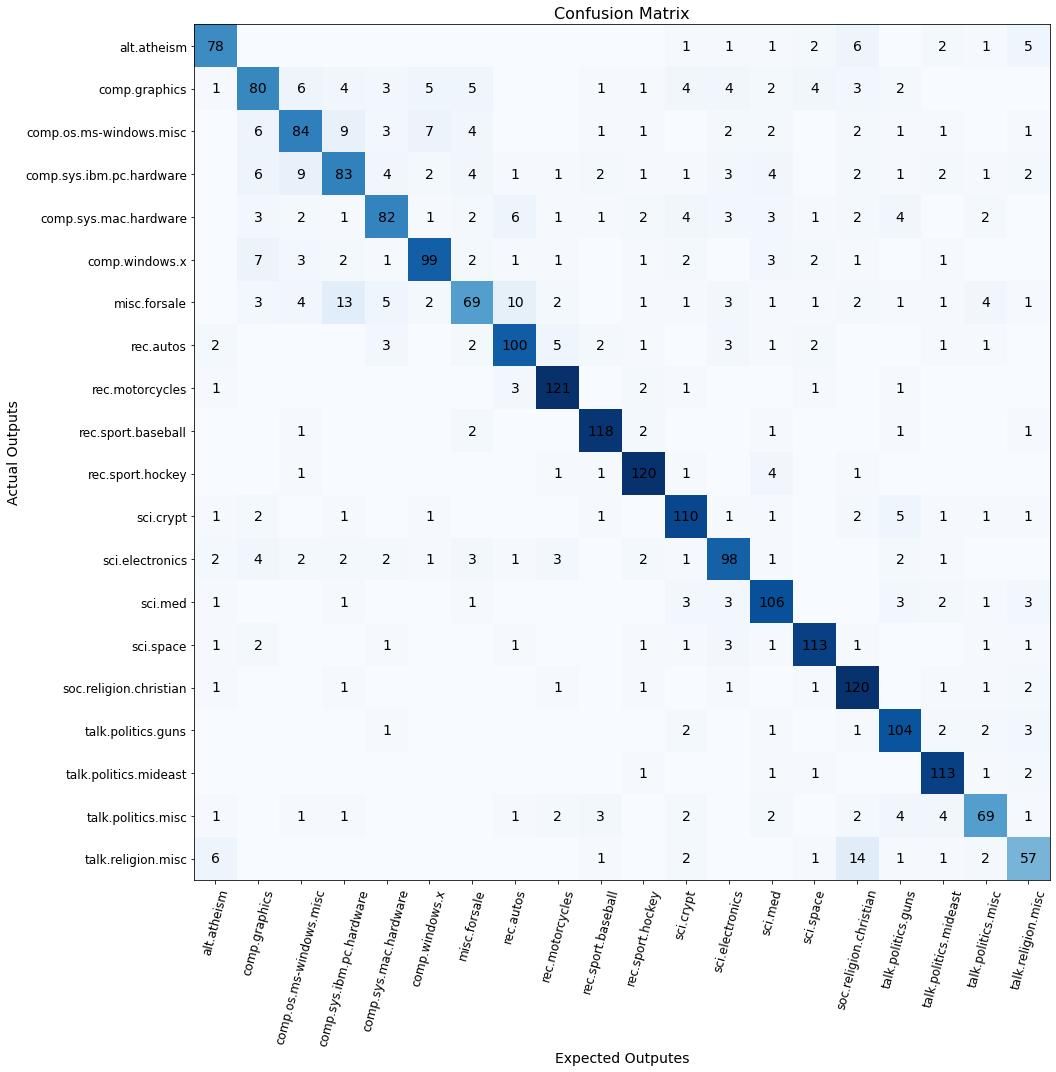

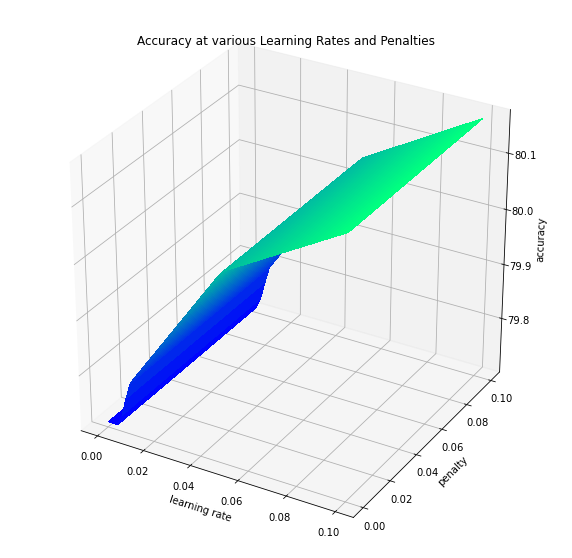

In [13]:
plot_accuracies(training_data,learning_rate_list,penalty_term_list,label_names)